# Analysis of Large Language Models on Input Method Editor Tasks

## Setup

### Libraries

In [1]:
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import pandas as pd
import numpy as np

### Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default

creds, _ = default()
gc = gspread.authorize(creds)

In [4]:
all_results = gc.open('Overall LLMs Result')
tasks = ['Chinese Words_Generation', 'Chinese Sentence_Generation', 'Japanese Words_Generation', 'Japanese Sentence_Generation', 'Chinese Error Correction', 'Japanese Error Correction']

### Constants

In [5]:
MODELS_METADATA = pd.DataFrame(gc.open('All Models').worksheet('Information').get_all_records()).set_index('Key');
MODELS_METADATA

,Name,Type
Key,,
P2H_HMM,P2H_HMM,baseline
P2H_DAG,P2H_DAG,baseline
sys_pinyin,macOS Pinyin,baseline
sys_japanese,macOS Kotoeri,baseline
opennmt,OpenNMT,baseline
pycorrector,pycorrector,baseline
qwen2,Qwen2-7B,local
baichuan,Baichuan-7B,local
claude3,Claude 3 Sonnet,online


In [6]:
FIGURES_FOLDER = '/content/drive/MyDrive/LLM exploration project/Figures'

### Functions

In [7]:
def get_model_type(model):
  return MODELS_METADATA.loc[model, 'Type']

def get_model_name(model):
  return MODELS_METADATA.loc[model, 'Name']

In [8]:
def load_results(task):
  sheet = all_results.worksheet(task)

  # check for nonunique headers
  headers = sheet.row_values(1)
  header_counts = Counter(headers)
  duplicates = [header for header, count in header_counts.items() if count > 1]

  if duplicates:
    print(f"Duplicated headers found: {duplicates}")

  data = sheet.get_all_records()
  df = pd.DataFrame(data)

  return df

In [9]:
def extract_gen_models(df):
  models = list(filter(lambda x: x.split('_')[-1] == 'gen', df.columns.values)) # filter out all gen models from columns
  models = list(set([x[:-4] for x in models])) # strip out model names

  return models

In [10]:
def extract_err_models(df):
  models = list(filter(lambda x: x[-21:] == '_incorrectstrings_gen', df.columns.values)) # filter out all gen models from columns
  models = list(set([x[:-21] for x in models])) # strip out model names

  return models

In [11]:
def make_columns_numeric(df, models):
  for model in models:
    df[model + '_simhash_textsim'] = pd.to_numeric(
        df[model + '_simhash_textsim'], errors='coerce'
    )

    df[model + '_time'] = pd.to_numeric(
        df[model + '_time'], errors='coerce'
    )

## Chinese Word Generation

### Processing

Fetch task results and models.

In [12]:
df = load_results('Chinese Words_Generation')
models = extract_gen_models(df)

make_columns_numeric(df, models)

In [13]:
models

['P2H_HMM',
 'gemini',
 'gemini2',
 'qwen2',
 'gpt4',
 'baichuan',
 'GLM4',
 'P2H_DAG',
 'gpt35',
 'llama32',
 'sys_pinyin',
 'claude3',
 'llama3',
 'mistral',
 'claude35',
 'gpt4o']

### All Results

Create index and columns for DataFrame. Will hold models mean performance for text similarity and time.

In [ ]:
models_index = pd.MultiIndex.from_tuples([(get_model_type(x), x) for x in models]).sort_values()
columns = ['textsim', 'time']

Create and populate the DataFrame.

In [ ]:
mean_df = pd.DataFrame(index=models_index, columns=columns, dtype='float64')

for model in models:
    mean_df.loc[(get_model_type(model), model), 'textsim'] = df[model + '_simhash_textsim'].mean()
    mean_df.loc[(get_model_type(model), model), 'time'] = df[model + '_time'].mean()

In [ ]:
mean_df

textsim      time
baseline P2H_DAG     0.805376  0.000302
         P2H_HMM     0.712887  0.317632
         sys_pinyin  0.819950  0.458478
local    GLM4        0.607061  0.486217
         baichuan    0.588546  3.110987
         llama3      0.581339  5.057033
         llama32     0.542759  0.370180
         mistral     0.571748  0.751184
         qwen2       0.696467  0.993146
online   claude3     0.665960  1.573525
         claude35    0.686079  2.847424
         gemini      0.685680  2.558618
         gemini2     0.807914  0.758133
         gpt35       0.712879  1.113347
         gpt4        0.762211  1.909171
         gpt4o       0.809468  0.980812

### Selected Results

In [ ]:
selected_models = ['gpt4o', 'gemini2','llama3', 'llama32', 'GLM4', 'sys_pinyin']

Extract selected data.

In [ ]:
selected_mean_df = mean_df.loc[pd.IndexSlice[:, selected_models], :]

In [ ]:
selected_mean_df

textsim      time
online   gpt4o       0.809468  0.980812
         gemini2     0.807914  0.758133
local    llama3      0.581339  5.057033
         llama32     0.542759  0.370180
         GLM4        0.607061  0.486217
baseline sys_pinyin  0.819950  0.458478

### Attribute Analysis

#### Text Similarity vs Word Length

##### Table

In [14]:
models_index = pd.MultiIndex.from_tuples([(get_model_type(x), x) for x in models]).sort_values()
columns = df['wl'].unique()

In [15]:
data = pd.DataFrame(index=models_index, columns=columns, dtype='float64')

for model in models:
  for wl in columns:
    data.loc[(get_model_type(model), model), wl] = df[df['wl'] == wl][model + '_simhash_textsim'].mean()

data

2         3         4         5         6  \
baseline P2H_DAG     0.740823  0.877147  0.680909  0.868151  0.864479   
         P2H_HMM     0.741363  0.765642  0.621887  0.751094  0.682896   
         sys_pinyin  0.620185  0.871998  0.729543  0.905217  0.918535   
local    GLM4        0.559437  0.616656  0.545533  0.709434  0.576406   
         baichuan    0.576635  0.586084  0.543767  0.657967  0.563555   
         llama3      0.539987  0.571576  0.541597  0.693038  0.562650   
         llama32     0.551754  0.538690  0.512118  0.573141  0.529972   
         mistral     0.566882  0.589539  0.549567  0.616873  0.556030   
         qwen2       0.668863  0.713694  0.613543  0.723958  0.722899   
online   claude3     0.621584  0.672468  0.692857  0.741814  0.576531   
         claude35    0.637583  0.700517  0.602577  0.761811  0.704116   
         gemini      0.618733  0.679373  0.604782  0.740304  0.715478   
         gemini2     0.677817  0.836378  0.692482  0.873737  0.876557   
         gpt35       0.665761  0.732377  0.606578  0.805345  0.722677   
         gpt4        0.671174  0.777454  0.630859  0.837720  0.848664   
         gpt4o       0.712145  0.803303  0.688629  0.886424  0.835717   

                            7         8         9  
baseline P2H_DAG     0.836456  0.770307  0.663598  
         P2H_HMM     0.674968  0.662542  0.744341  
         sys_pinyin  0.940277  0.918784  0.740425  
local    GLM4        0.655491  0.615844  0.651238  
         baichuan    0.607307  0.592718  0.630899  
         llama3      0.608149  0.601224  0.577752  
         llama32     0.553781  0.533731  0.548671  
         mistral     0.567140  0.539609  0.528367  
         qwen2       0.764008  0.695223  0.607174  
online   claude3     0.691764  0.680811  0.802136  
         claude35    0.710229  0.756068  0.573064  
         gemini      0.775626  0.790711  0.544367  
         gemini2     0.889910  0.934136  0.824786  
         gpt35       0.764579  0.735768  0.649297  
         gpt4        0.835725  0.814204  0.763023  
         gpt4o       0.914628  0.978040  0.804377

##### Figures

Model Order

In [16]:
models_order = ['gpt35', 'gpt4', 'gpt4o', 'claude3', 'claude35', 'gemini',
                'gemini2', 'llama3', 'llama32', 'mistral', 'GLM4', 'baichuan',
                'qwen2', 'P2H_HMM', 'P2H_DAG', 'sys_pinyin']

All models on one bar chart

In [ ]:
#selected_data = data.loc[pd.IndexSlice[:, selected_models], :]

# plt.figure(figsize=(12, 6))  # Adjust figure size as needed
# sns.barplot(x='wl', y='textsim', hue='model', data=melted_df)
# plt.xlabel('Word Length')
# plt.ylabel('Text Similarity (Simhash)')
# plt.title('Chinese Word Generation: Text Similarity vs Word Length of All Models')
# plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside plot
# plt.tight_layout() #prevents legend cutoff
# plt.show()

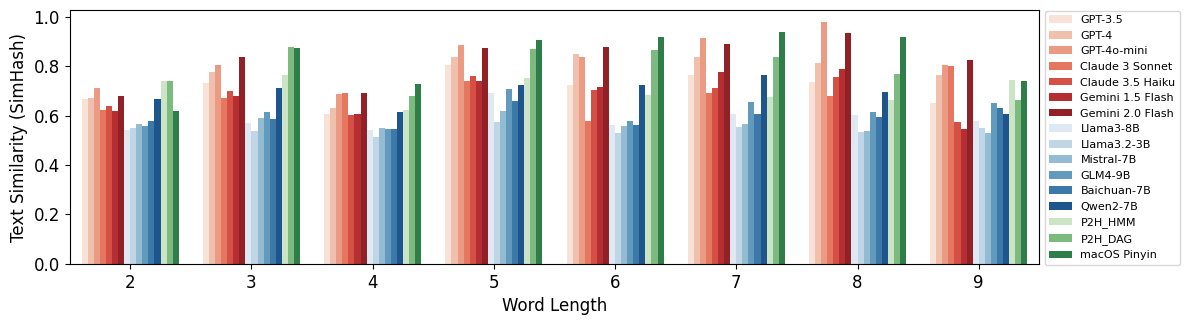

In [17]:
melted_df = pd.melt(data.droplevel(0).reindex(models_order).rename(MODELS_METADATA['Name'].to_dict()).
                    reset_index(names=['model']), id_vars='model', var_name='wl', value_name='textsim')



# Define model categories
model_categories = {
    'Closed-Source LLMs': ['GPT-3.5', 'GPT-4', 'GPT-4o-mini', 'Claude 3 Sonnet', 'Claude 3.5 Haiku', 'Gemini 1.5 Flash', 'Gemini 2.0 Flash'],
    'Open-Source LLMs': ['Llama3-8B', 'Llama3.2-3B', 'Mistral-7B', 'GLM4-9B', 'Baichuan-7B', 'Qwen2-7B'],
    'Traditional IMEs': ['P2H_HMM', 'P2H_DAG', 'macOS Pinyin']
}

# Assign a category to each model
category_map = {model: cat for cat, models in model_categories.items() for model in models}
melted_df['category'] = melted_df['model'].map(category_map)

# Create a color palette grouped by categories
palette = {
    'Closed-Source LLMs': sns.color_palette('Reds', n_colors=len(model_categories['Closed-Source LLMs'])),
    'Open-Source LLMs': sns.color_palette('Blues', n_colors=len(model_categories['Open-Source LLMs'])),
    'Traditional IMEs': sns.color_palette('Greens', n_colors=len(model_categories['Traditional IMEs']))
}

# Flatten the palette colors to match the model order in the dataframe
flat_palette = []
for cat in ['Closed-Source LLMs', 'Open-Source LLMs', 'Traditional IMEs']:
    flat_palette.extend(palette[cat])

# Order the models according to categories for consistent plotting
ordered_models = sum(model_categories.values(), [])

plt.figure(figsize=(12, 3.35))
sns.barplot(x='wl', y='textsim', hue='model', data=melted_df, hue_order=ordered_models, palette=flat_palette)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Word Length', fontsize=12)
plt.ylabel('Text Similarity (SimHash)', fontsize=12)
# plt.title('Chinese Word Generation: Text Similarity vs Word Length by Model Category')
plt.legend(title='', bbox_to_anchor=(1.0, 1.02), loc='upper left', fontsize=8)
plt.tight_layout()

plt.savefig(f'{FIGURES_FOLDER}/cwg_textsim_wl.pdf', format='pdf', bbox_inches='tight')
plt.show()

#### Time vs Word Length

##### Table

In [18]:
models_index = pd.MultiIndex.from_tuples([(get_model_type(x), x) for x in models]).sort_values()
columns = df['wl'].unique()

In [19]:
data = pd.DataFrame(index=models_index, columns=columns, dtype='float64')

for model in models:
  for wl in columns:
    data.loc[(get_model_type(model), model), wl] = df[df['wl'] == wl][model + '_time'].mean()

data

2         3         4         5         6  \
baseline P2H_DAG     0.000221  0.000212  0.000230  0.000249  0.000265   
         P2H_HMM     0.073984  0.272576  0.399985  0.266348  0.307560   
         sys_pinyin  0.264523  0.336685  0.426262  0.499984  0.568597   
local    GLM4        0.311380  0.382310  0.482348  0.524776  0.591552   
         baichuan    2.096723  2.336564  3.135344  3.358450  3.738578   
         llama3      3.090843  3.759607  4.673735  5.178389  6.431450   
         llama32     0.236920  0.288424  0.357565  0.404415  0.457489   
         mistral     0.675745  0.680214  0.629009  0.849917  0.734722   
         qwen2       0.474007  0.674267  0.884061  1.107340  1.287931   
online   claude3     1.146255  1.349553  1.631725  1.585345  1.670068   
         claude35    2.278786  2.994148  2.996064  3.002157  2.986996   
         gemini      1.928086  2.291800  3.068321  2.323042  2.725593   
         gemini2     0.743203  1.227492  0.606082  0.585960  0.542857   
         gpt35       0.935459  1.049584  1.102563  1.125680  1.174531   
         gpt4        1.584814  1.734691  1.906610  1.987492  2.135974   
         gpt4o       0.984962  1.021030  0.956383  0.906513  0.956043   

                            7         8          9  
baseline P2H_DAG     0.000279  0.001104   0.000247  
         P2H_HMM     0.434582  0.891810   0.468607  
         sys_pinyin  0.664902  0.738992   0.946236  
local    GLM4        0.665877  0.712503   0.787671  
         baichuan    4.297109  4.532382   5.023607  
         llama3      6.813664  8.247262  11.902766  
         llama32     0.503234  0.535549   0.665452  
         mistral     0.961860  0.789341   1.319337  
         qwen2       1.600557  1.708597   2.169309  
online   claude3     2.072208  2.194553   2.513435  
         claude35    3.013799  2.997975   3.034307  
         gemini      3.223348  3.479668   2.312415  
         gemini2     0.556092  0.546837   1.023012  
         gpt35       1.274140  1.389222   1.402986  
         gpt4        2.271413  2.226132   2.215323  
         gpt4o       0.962794  1.095677   0.922016

##### Figures

Model Order

In [20]:
models_order = ['gpt35', 'gpt4', 'gpt4o', 'claude3', 'claude35', 'gemini', 'gemini2',
                'llama3', 'llama32', 'mistral', 'GLM4', 'baichuan', 'qwen2', 'P2H_HMM', 'P2H_DAG', 'sys_pinyin']

In [21]:
melted_df = pd.melt(data.droplevel(0).reindex(models_order).rename(MODELS_METADATA['Name'].to_dict()).reset_index(names=['model']), id_vars='model', var_name='wl', value_name='time')
melted_df

,model,wl,time
0,GPT-3.5,2,0.935459
1,GPT-4,2,1.584814
2,GPT-4o-mini,2,0.984962
3,Claude 3 Sonnet,2,1.146255
4,Claude 3.5 Haiku,2,2.278786
...,...,...,...
123,Baichuan-7B,9,5.023607
124,Qwen2-7B,9,2.169309
125,P2H_HMM,9,0.468607
126,P2H_DAG,9,0.000247


All models on one bar chart

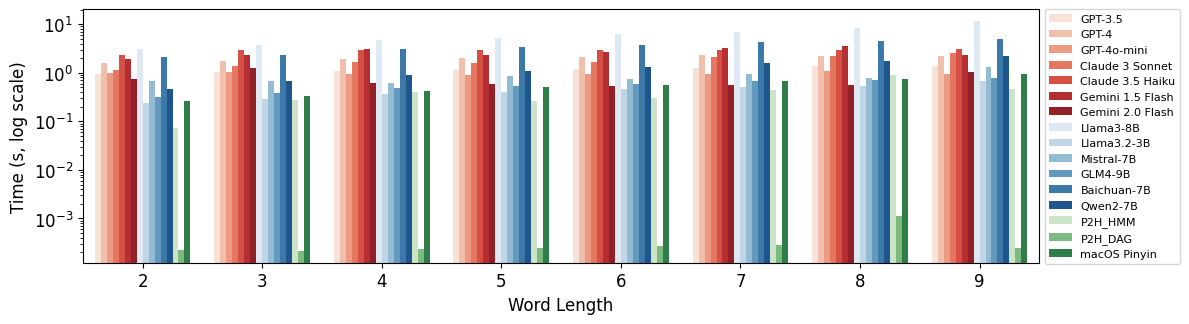

In [22]:
# Define model categories

model_categories = {
    'Closed-Source LLMs': ['GPT-3.5', 'GPT-4', 'GPT-4o-mini', 'Claude 3 Sonnet', 'Claude 3.5 Haiku', 'Gemini 1.5 Flash', 'Gemini 2.0 Flash'],
    'Open-Source LLMs': ['Llama3-8B', 'Llama3.2-3B', 'Mistral-7B', 'GLM4-9B', 'Baichuan-7B', 'Qwen2-7B'],
    'Traditional IMEs': ['P2H_HMM', 'P2H_DAG', 'macOS Pinyin']
}

# Assign a category to each model
category_map = {model: cat for cat, models in model_categories.items() for model in models}
melted_df['category'] = melted_df['model'].map(category_map)

# Create a color palette grouped by categories
palette = {
    'Closed-Source LLMs': sns.color_palette('Reds', n_colors=len(model_categories['Closed-Source LLMs'])),
    'Open-Source LLMs': sns.color_palette('Blues', n_colors=len(model_categories['Open-Source LLMs'])),
    'Traditional IMEs': sns.color_palette('Greens', n_colors=len(model_categories['Traditional IMEs']))
}

# Flatten the palette colors to match the model order in the dataframe
flat_palette = []
for cat in ['Closed-Source LLMs', 'Open-Source LLMs', 'Traditional IMEs']:
    flat_palette.extend(palette[cat])

# Order the models according to categories for consistent plotting
ordered_models = sum(model_categories.values(), [])

plt.figure(figsize=(12, 3.35))
sns.barplot(x='wl', y='time', hue='model', data=melted_df, hue_order=ordered_models, palette=flat_palette)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Word Length', fontsize=12)
plt.yscale('log')
plt.ylabel('Time (s, log scale)', fontsize=12)
# plt.title('Chinese Word Generation: Time vs Word Length by Model Category')
plt.legend(title='', bbox_to_anchor=(1.0, 1.02), loc='upper left', fontsize=8)
plt.tight_layout()

plt.savefig(f'{FIGURES_FOLDER}/cwg_time_wl.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Chinese Sentence Generation

In [23]:
df = load_results('Chinese Sentence_Generation')
models = extract_gen_models(df)
make_columns_numeric(df, models)

<Axes: xlabel='len', ylabel='Count'>

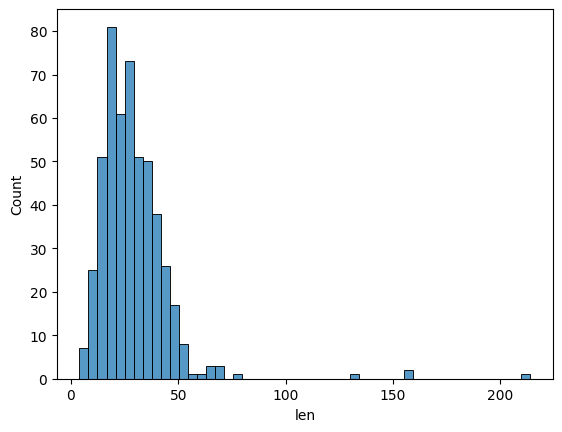

In [24]:
sns.histplot(df['len'])

In [25]:
# bucket of ranges
columns = ['4-14', '14-24', '24-34', '34-44', '44+']

df['len_bin'] = pd.cut(df['len'], bins=[4, 14, 24, 34, 44, np.inf], labels=columns)

In [26]:
data = pd.DataFrame(index=models, columns=columns, dtype='float64')

for model in models:
  for sl in columns:
    data.loc[model, sl] = df[df['len_bin'] == sl][model + '_simhash_textsim'].mean()

data

,4-14,14-24,24-34,34-44,44+
P2H_HMM,0.706433,0.731793,0.675179,0.669437,0.658358
gemini,0.812512,0.796941,0.771126,0.780369,0.794099
gemini2,0.925934,0.875678,0.877825,0.874527,0.851265
qwen2,0.631899,0.613535,0.598880,0.601708,0.640000
gpt4,0.917034,0.907563,0.880173,0.871035,0.828445
baichuan,0.639179,0.598033,0.573309,0.580494,0.565950
GLM4,0.517432,0.517848,0.513606,0.501868,0.514738
P2H_DAG,0.693267,0.754907,0.714801,0.735908,0.720658
gpt35,0.837047,0.854684,0.829724,0.827349,0.802058
claude3,0.875641,0.856440,0.835977,0.806612,0.802733


Model Order

In [28]:
models_order = ['gpt35', 'gpt4', 'gpt4o', 'claude3', 'claude35', 'gemini', 'gemini2', 'llama3', 'llama32', 'mistral', 'GLM4', 'baichuan', 'qwen2', 'P2H_HMM', 'P2H_DAG', 'sys_pinyin']

In [29]:
data.reindex(models_order).rename(index=MODELS_METADATA['Name'].to_dict())

,4-14,14-24,24-34,34-44,44+
GPT-3.5,0.837047,0.854684,0.829724,0.827349,0.802058
GPT-4,0.917034,0.907563,0.880173,0.871035,0.828445
GPT-4o-mini,0.887830,0.847001,0.828538,0.820059,0.784626
Claude 3 Sonnet,0.875641,0.856440,0.835977,0.806612,0.802733
Claude 3.5 Haiku,0.859873,0.839350,0.834553,0.818644,0.788686
Gemini 1.5 Flash,0.812512,0.796941,0.771126,0.780369,0.794099
Gemini 2.0 Flash,0.925934,0.875678,0.877825,0.874527,0.851265
Llama3-8B,0.648909,0.660497,0.613510,0.613606,0.580613
Llama3.2-3B,0.567775,0.556680,0.530853,0.526804,0.514678
Mistral-7B,0.605585,0.579219,0.558440,0.561190,0.580312


### Text Similarity Vs Sentence Length

In [30]:
models_order = ['gpt35', 'gpt4', 'gpt4o', 'claude3', 'claude35', 'gemini', 'gemini2',
                'llama3', 'llama32', 'mistral', 'GLM4', 'baichuan', 'qwen2', 'P2H_HMM', 'P2H_DAG', 'sys_pinyin']

In [31]:
melted_df = pd.melt(data.reindex(models_order).rename(index=MODELS_METADATA['Name'].to_dict()).
                    reset_index(names=['model']), id_vars='model', var_name='wl', value_name='textsim')
melted_df

,model,wl,textsim
0,GPT-3.5,4-14,0.837047
1,GPT-4,4-14,0.917034
2,GPT-4o-mini,4-14,0.887830
3,Claude 3 Sonnet,4-14,0.875641
4,Claude 3.5 Haiku,4-14,0.859873
...,...,...,...
75,Baichuan-7B,44+,0.565950
76,Qwen2-7B,44+,0.640000
77,P2H_HMM,44+,0.658358
78,P2H_DAG,44+,0.720658


All models on one bar chart

In [ ]:
'''
melted_df = pd.melt(data.reindex(models_order).rename(index=MODELS_METADATA['Name'].to_dict()).
                    reset_index(names=['model']), id_vars='model', var_name='wl', value_name='textsim')

plt.figure(figsize=(12, 6))  # Adjust figure size as needed
sns.barplot(x='wl', y='textsim', hue='model', data=melted_df)
plt.xlabel('Sentence Length')
plt.ylabel('Text Similarity (Simhash)')
plt.title('Chinese Sentence Generation: Text Similarity vs Sentence Length of All Models')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside plot
plt.tight_layout() #prevents legend cutoff
plt.show()
'''

"\nmelted_df = pd.melt(data.reindex(models_order).rename(index=MODELS_METADATA['Name'].to_dict()).\n                    reset_index(names=['model']), id_vars='model', var_name='wl', value_name='textsim')\n\nplt.figure(figsize=(12, 6))  # Adjust figure size as needed\nsns.barplot(x='wl', y='textsim', hue='model', data=melted_df)\nplt.xlabel('Sentence Length')\nplt.ylabel('Text Similarity (Simhash)')\nplt.title('Chinese Sentence Generation: Text Similarity vs Sentence Length of All Models')\nplt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside plot\nplt.tight_layout() #prevents legend cutoff\nplt.show()\n"

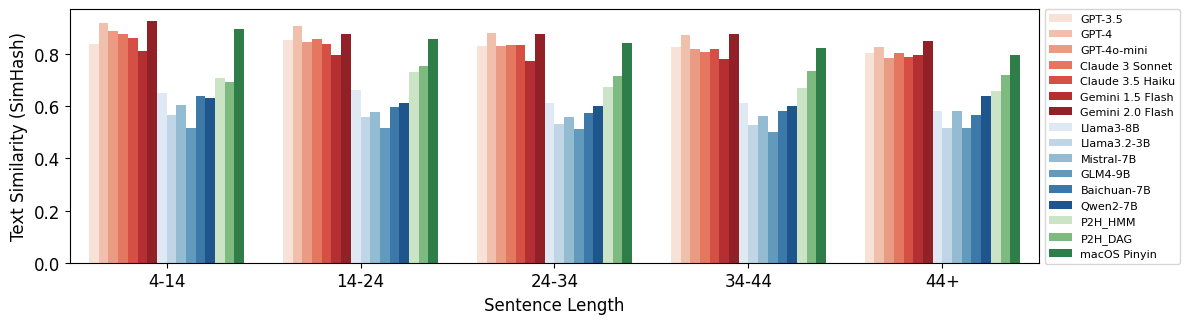

In [33]:
#melted_df = pd.melt(data.reindex(models_order).rename(index=MODELS_METADATA['Name'].to_dict()).reset_index(names=['model']), id_vars='model', var_name='wl', value_name='textsim')

# Define model categories
'''
model_categories = {
    'Closed-Source LLMs': ['GPT-3.5', 'GPT-4', 'GPT-4o-mini', 'Claude 3 Sonnet', 'Claude 3.5 Haiku', 'Gemini 1.5 Flash', 'Gemini 2.0 Flash'],
    'Open-Source LLMs': ['Llama3-8B', 'Llama3.2-3B', 'Mistral-7B', 'GLM4-9B', 'Baichuan-7B', 'Qwen2-7B'],
    'Traditional IMEs': ['P2H_HMM', 'P2H_DAG', 'macOS Pinyin']
}
'''
model_categories = {
    'Closed-Source LLMs': ['GPT-3.5', 'GPT-4', 'GPT-4o-mini', 'Claude 3 Sonnet', 'Claude 3.5 Haiku', 'Gemini 1.5 Flash', 'Gemini 2.0 Flash'],
    'Open-Source LLMs': ['Llama3-8B', 'Llama3.2-3B', 'Mistral-7B', 'GLM4-9B', 'Baichuan-7B', 'Qwen2-7B'],
    'Traditional IMEs': ['P2H_HMM', 'P2H_DAG', 'macOS Pinyin']
}

# Assign a category to each model
category_map = {model: cat for cat, models in model_categories.items() for model in models}
melted_df['category'] = melted_df['model'].map(category_map)

# Create a color palette grouped by categories
palette = {
    'Closed-Source LLMs': sns.color_palette('Reds', n_colors=len(model_categories['Closed-Source LLMs'])),
    'Open-Source LLMs': sns.color_palette('Blues', n_colors=len(model_categories['Open-Source LLMs'])),
    'Traditional IMEs': sns.color_palette('Greens', n_colors=len(model_categories['Traditional IMEs']))
}

# Flatten the palette colors to match the model order in the dataframe
flat_palette = []
for cat in ['Closed-Source LLMs', 'Open-Source LLMs', 'Traditional IMEs']:
    flat_palette.extend(palette[cat])

# Order the models according to categories for consistent plotting
ordered_models = sum(model_categories.values(), [])

plt.figure(figsize=(12, 3.35))
sns.barplot(x='wl', y='textsim', hue='model', data=melted_df, hue_order=ordered_models, palette=flat_palette)


plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Sentence Length', fontsize=12)
plt.ylabel('Text Similarity (SimHash)', fontsize=12)

# plt.title('Chinese Sentence Generation: Text Similarity vs Sentence Length by Model Category')
plt.legend(title='', bbox_to_anchor=(1.0, 1.02), loc='upper left', fontsize=8)
plt.tight_layout()

plt.savefig(f'{FIGURES_FOLDER}/csg_textsim_wl.pdf', format='pdf', bbox_inches='tight')
plt.show()


### Time Vs Sentence Length

In [34]:
df = load_results('Chinese Sentence_Generation')
models = extract_gen_models(df)
make_columns_numeric(df, models)

<Axes: xlabel='len', ylabel='Count'>

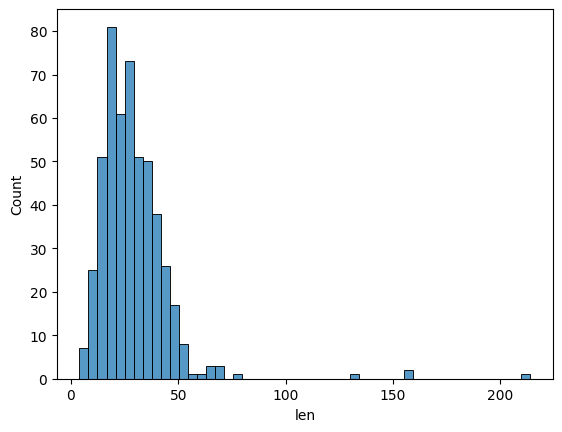

In [35]:
sns.histplot(df['len'])

In [36]:
# bucket of ranges
columns = ['4-14', '14-24', '24-34', '34-44', '44+']

df['len_bin'] = pd.cut(df['len'], bins=[4, 14, 24, 34, 44, np.inf], labels=columns)

In [37]:
data = pd.DataFrame(index=models, columns=columns, dtype='float64')

for model in models:
  for sl in columns:
    data.loc[model, sl] = df[df['len_bin'] == sl][model + '_time'].mean()

data

,4-14,14-24,24-34,34-44,44+
P2H_HMM,0.526258,0.836843,0.846899,1.115785,2.220337
gemini,1.709568,2.170317,2.433583,2.536666,2.661676
gemini2,0.620747,0.722953,0.770254,0.799693,0.947933
qwen2,2.051243,2.268792,3.504185,4.298521,5.294862
gpt4,2.897353,3.615199,4.533444,5.244206,6.407132
baichuan,0.868578,1.271851,2.747566,2.008281,2.752980
GLM4,2.778100,2.720967,2.702856,2.615775,3.071754
P2H_DAG,0.000985,0.001193,0.001594,0.002372,0.006167
gpt35,1.240805,1.449751,1.671767,1.817758,2.669002
claude3,1.964653,2.401204,3.036117,3.545171,5.527964


In [38]:
models_order = ['gpt35', 'gpt4', 'gpt4o', 'claude3', 'claude35', 'gemini', 'gemini2', 'llama3', 'llama32', 'mistral', 'GLM4', 'baichuan', 'qwen2', 'P2H_HMM', 'P2H_DAG', 'sys_pinyin']

In [39]:
data.reindex(models_order).rename(index=MODELS_METADATA['Name'].to_dict())

,4-14,14-24,24-34,34-44,44+
GPT-3.5,1.240805,1.449751,1.671767,1.817758,2.669002
GPT-4,2.897353,3.615199,4.533444,5.244206,6.407132
GPT-4o-mini,1.050744,1.183508,1.464751,1.576690,1.914527
Claude 3 Sonnet,1.964653,2.401204,3.036117,3.545171,5.527964
Claude 3.5 Haiku,2.309180,2.843063,3.112468,3.405885,4.502882
Gemini 1.5 Flash,1.709568,2.170317,2.433583,2.536666,2.661676
Gemini 2.0 Flash,0.620747,0.722953,0.770254,0.799693,0.947933
Llama3-8B,1.043161,1.565357,2.417553,3.356839,5.830110
Llama3.2-3B,0.728931,1.017201,1.112756,1.104558,1.174059
Mistral-7B,0.930376,1.053205,1.312989,1.496619,1.893162


In [40]:
melted_df = pd.melt(data.reindex(models_order).rename(index=MODELS_METADATA['Name'].to_dict()).reset_index(names=['model']), id_vars='model', var_name='wl', value_name='time')
melted_df

,model,wl,time
0,GPT-3.5,4-14,1.240805
1,GPT-4,4-14,2.897353
2,GPT-4o-mini,4-14,1.050744
3,Claude 3 Sonnet,4-14,1.964653
4,Claude 3.5 Haiku,4-14,2.309180
...,...,...,...
75,Baichuan-7B,44+,2.752980
76,Qwen2-7B,44+,5.294862
77,P2H_HMM,44+,2.220337
78,P2H_DAG,44+,0.006167


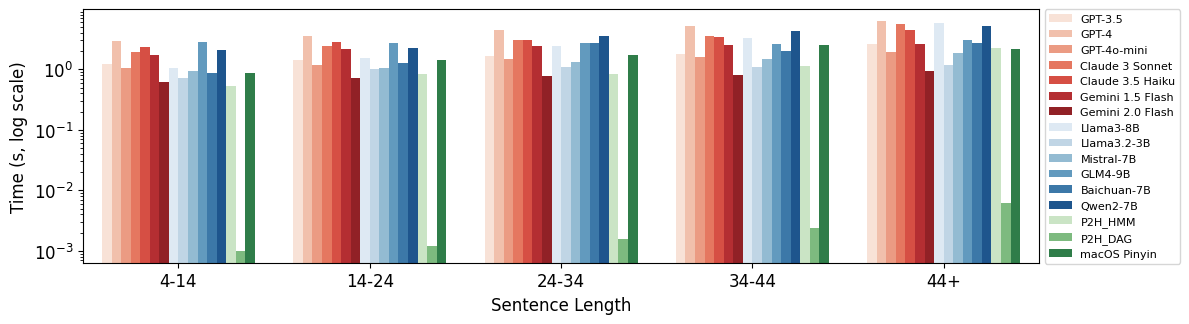

In [41]:
melted_df = pd.melt(data.reindex(models_order).rename(index=MODELS_METADATA['Name'].to_dict()).
                    reset_index(names=['model']), id_vars='model', var_name='wl', value_name='time')

# Define model categories
'''
model_categories = {
    'Closed-Source LLMs': ['GPT3.5', 'GPT4', 'GPT4o Mini', 'Claude3 Sonnet', 'Claude3.5 Haiku', 'Gemini1.5 Flash', 'Gemini2.0 Flash'],
    'Open-Source LLMs': ['Llama3-8B', 'Llama3.2-3B', 'Mistral-7B', 'GLM4-9B', 'Baichuan-7B', 'Qwen2-7B'],
    'Traditional IMEs': ['P2H-DAG', 'P2H-HMM', 'macOS Pinyin']
}
'''

model_categories = {
    'Closed-Source LLMs': ['GPT-3.5', 'GPT-4', 'GPT-4o-mini', 'Claude 3 Sonnet', 'Claude 3.5 Haiku', 'Gemini 1.5 Flash', 'Gemini 2.0 Flash'],
    'Open-Source LLMs': ['Llama3-8B', 'Llama3.2-3B', 'Mistral-7B', 'GLM4-9B', 'Baichuan-7B', 'Qwen2-7B'],
    'Traditional IMEs': ['P2H_HMM', 'P2H_DAG', 'macOS Pinyin']
}

# Assign a category to each model
category_map = {model: cat for cat, models in model_categories.items() for model in models}
melted_df['category'] = melted_df['model'].map(category_map)

# Create a color palette grouped by categories
palette = {
    'Closed-Source LLMs': sns.color_palette('Reds', n_colors=len(model_categories['Closed-Source LLMs'])),
    'Open-Source LLMs': sns.color_palette('Blues', n_colors=len(model_categories['Open-Source LLMs'])),
    'Traditional IMEs': sns.color_palette('Greens', n_colors=len(model_categories['Traditional IMEs']))
}

# Flatten the palette colors to match the model order in the dataframe
flat_palette = []
for cat in ['Closed-Source LLMs', 'Open-Source LLMs', 'Traditional IMEs']:
    flat_palette.extend(palette[cat])

# Order the models according to categories for consistent plotting
ordered_models = sum(model_categories.values(), [])

plt.figure(figsize=(12, 3.35))
sns.barplot(x='wl', y='time', hue='model', data=melted_df, hue_order=ordered_models, palette=flat_palette)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Sentence Length', fontsize=12)
plt.yscale('log')
plt.ylabel('Time (s, log scale)', fontsize=12)
# plt.title('Chinese Sentence Generation: Text Similarity vs Sentence Length by Model Category')
plt.legend(title='', bbox_to_anchor=(1.0, 1.02), loc='upper left', fontsize=8)
plt.tight_layout()

plt.savefig(f'{FIGURES_FOLDER}/csg_time_wl.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Japanese Words Generation

All Results

In [12]:
df = load_results('Japanese Words_Generation')
models = extract_gen_models(df)
make_columns_numeric(df, models)

In [13]:
models.remove("wana")

In [14]:
models

['gpt4o',
 'gemini2',
 'llama32',
 'GLM4',
 'gpt35',
 'rakuten2',
 'llama3',
 'claude3',
 'mistral',
 'sys_japanese',
 'rakuten',
 'gpt4',
 'claude35',
 'gemini',
 'rinna']

<Axes: xlabel='len', ylabel='Count'>

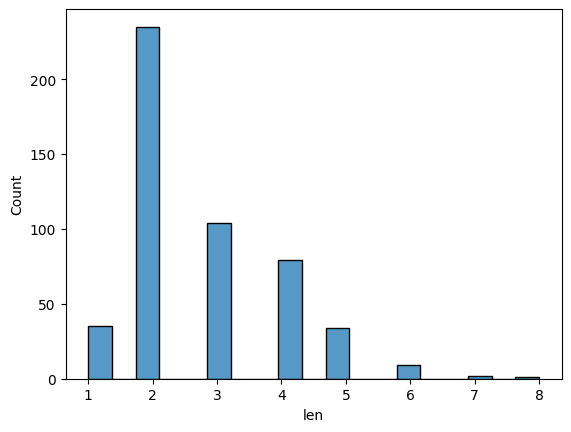

In [15]:
sns.histplot(df['len'])

In [16]:
models_index = pd.MultiIndex.from_tuples([(get_model_type(x), x) for x in models]).sort_values()
columns = ['textsim', 'time']

Create and populate the DataFrame.

In [17]:
mean_df = pd.DataFrame(index=models_index, columns=columns, dtype='float64')

for model in models:
    mean_df.loc[(get_model_type(model), model), 'textsim'] = df[model + '_simhash_textsim'].mean()

    mean_df.loc[(get_model_type(model), model), 'time'] = df[model + '_time'].mean()

#for model in models:
#    mean_df.loc[(get_model_type(model), model), 'textsim'] = df[model + '_simhash_textsim'].mean()
#    mean_df.loc[(get_model_type(model), model), 'time'] = df[model + '_time'].mean()

In [48]:
mean_df

textsim      time
baseline sys_japanese  0.736259  0.310855
local    GLM4          0.627935  0.389099
         llama3        0.587391  3.623958
         llama32       0.617649  0.274380
         mistral       0.683763  0.502139
         rakuten       0.636474  0.620602
         rakuten2      0.548312  1.249920
         rinna         0.548584  0.205819
online   claude3       0.783465  0.911304
         claude35      0.794067  2.884296
         gemini        0.755932  1.038204
         gemini2       0.830597  0.495492
         gpt35         0.755757  0.742303
         gpt4          0.776271  1.452203
         gpt4o         0.790704  0.886719

In [18]:
models_order = ['gpt35', 'gpt4', 'gpt4o', 'claude3', 'claude35', 'gemini', 'gemini2', 'llama3', 'llama32', 'mistral', 'GLM4', 'rakuten', 'rakuten2', 'rinna', 'sys_japanese']

#### Overall TextSimilarity VS Word length

In [19]:
# models_index = pd.MultiIndex.from_tuples([(get_model_type(x), x) for x in models]).sort_values()
columns = df['len'].unique()


In [20]:
columns

array([2, 5, 3, 4, 1, 6, 7, 8])

In [21]:
data = pd.DataFrame(index=models, columns=columns, dtype='float64')

#for model in models:
#    for wl in columns:
#        mask = (df['len'] == wl)
#        col_name = model + '_simhash_textsim'
#        if col_name in df.columns:
            # Convert to numeric, forcing invalid values like '' to NaN
#            numeric_series = pd.to_numeric(df.loc[mask, col_name], errors='coerce')
#            mean_val = numeric_series.mean()
#            data.loc[model, wl] = mean_val

for model in models:
    for wl in columns:
        mask = (df['len'] == wl)
        col_name = model + '_simhash_textsim'
        if col_name in df.columns:
            mean_val = df.loc[mask, col_name].mean()
            data.loc[model, wl] = mean_val


data

,2,5,3,4,1,6,7,8
gpt4o,0.771706,0.895624,0.794472,0.882739,0.635957,0.667703,0.780303,0.569231
gemini2,0.823919,0.877212,0.852878,0.866740,0.668439,0.828283,1.000000,1.000000
llama32,0.561653,0.699202,0.661118,0.717690,0.541325,0.666667,0.810606,0.424242
GLM4,0.580660,0.679395,0.669550,0.698818,0.581671,0.717716,0.631866,0.863636
gpt35,0.749813,0.763465,0.803389,0.801956,0.624529,0.522637,0.518415,0.453125
rakuten2,0.531232,0.646231,0.561533,0.557961,0.509277,0.508392,0.666667,0.584615
llama3,0.566152,0.685914,0.569990,0.663095,0.517109,0.602020,0.568182,0.424242
claude3,0.740231,0.928604,0.818737,0.877098,0.605571,0.806397,0.765152,1.000000
mistral,0.614904,0.835283,0.723732,0.784480,0.606733,0.809764,0.765152,1.000000
sys_japanese,0.756344,0.731360,0.741251,0.732241,0.576883,0.786946,0.787879,1.000000


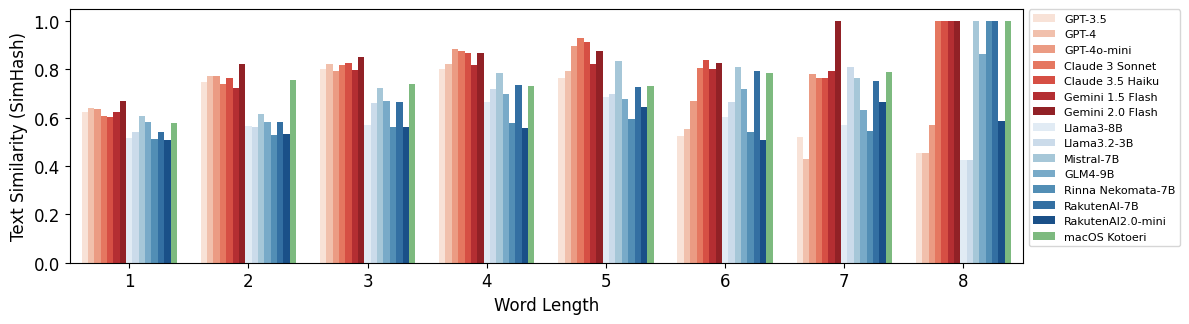

In [22]:
melted_df = pd.melt(data.reindex(models_order).rename(index=MODELS_METADATA['Name'].to_dict()).
                    reset_index(names=['model']), id_vars='model', var_name='wl', value_name='textsim')

# Define model categories
model_categories = {
    'Closed-Source LLMs': ['GPT-3.5', 'GPT-4', 'GPT-4o-mini', 'Claude 3 Sonnet', 'Claude 3.5 Haiku', 'Gemini 1.5 Flash', 'Gemini 2.0 Flash'],
    'Open-Source LLMs': ['Llama3-8B', 'Llama3.2-3B', 'Mistral-7B', 'GLM4-9B', 'Rinna Nekomata-7B', 'RakutenAI-7B',
'RakutenAI2.0-mini'],
    'Traditional IMEs': ['macOS Kotoeri']
}

# Assign a category to each model
category_map = {model: cat for cat, models in model_categories.items() for model in models}
melted_df['category'] = melted_df['model'].map(category_map)

# Create a color palette grouped by categories
palette = {
    'Closed-Source LLMs': sns.color_palette('Reds', n_colors=len(model_categories['Closed-Source LLMs'])),
    'Open-Source LLMs': sns.color_palette('Blues', n_colors=len(model_categories['Open-Source LLMs'])),
    'Traditional IMEs': sns.color_palette('Greens', n_colors=len(model_categories['Traditional IMEs']))
}

# Flatten the palette colors to match the model order in the dataframe
flat_palette = []
for cat in ['Closed-Source LLMs', 'Open-Source LLMs', 'Traditional IMEs']:
    flat_palette.extend(palette[cat])

# Order the models according to categories for consistent plotting
ordered_models = sum(model_categories.values(), [])

plt.figure(figsize=(12, 3.35))
sns.barplot(x='wl', y='textsim', hue='model', data=melted_df, hue_order=ordered_models, palette=flat_palette)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Word Length', fontsize=12)
plt.ylabel('Text Similarity (SimHash)', fontsize=12)
# plt.title('Chinese Sentence Generation: Text Similarity vs Sentence Length by Model Category')
plt.legend(title='', bbox_to_anchor=(1.0, 1.02), loc='upper left', fontsize=8)
plt.tight_layout()

plt.savefig(f'{FIGURES_FOLDER}/jwg_overall_textsim_wl.pdf', format='pdf', bbox_inches='tight')
plt.show()


#### Overall Time VS Word length

In [23]:
data = pd.DataFrame(index=models, columns=columns, dtype='float64')
'''
for model in models:
    for wl in columns:
        mask = (df['len'] == wl)
        col_name = model + '_time'
        if col_name in df.columns:
            # Convert to numeric, forcing invalid values like '' to NaN
            numeric_series = pd.to_numeric(df.loc[mask, col_name], errors='coerce')
            mean_val = numeric_series.mean()
            data.loc[model, wl] = mean_val
data=data.drop(columns=[""])
'''

for model in models:
    for wl in columns:
        mask = (df['len'] == wl)
        col_name = model + '_time'
        if col_name in df.columns:
            mean_val = df.loc[mask, col_name].mean()
            data.loc[model, wl] = mean_val
data

,2,5,3,4,1,6,7,8
gpt4o,0.904535,0.872084,0.885487,0.872401,0.801853,0.815698,1.555523,0.728673
gemini2,0.506720,0.502979,0.475914,0.492504,0.477938,0.494866,0.486947,0.511683
llama32,0.253431,0.347808,0.272374,0.312925,0.209257,0.425248,0.443135,0.448509
GLM4,0.363353,0.480159,0.397074,0.432569,0.290127,0.543085,0.620243,0.695955
gpt35,0.749883,0.723627,0.763583,0.712699,0.719657,0.733979,0.705559,0.662779
rakuten2,1.258514,1.320087,1.208406,1.258346,1.202498,1.296987,1.382329,1.467969
llama3,3.390651,4.299884,3.227867,5.071027,2.359838,3.733850,5.236678,2.374312
claude3,0.919746,0.867123,0.860448,1.010060,0.860794,0.798006,0.919095,0.688735
mistral,0.503275,0.520607,0.479037,0.502118,0.535333,0.534826,0.482574,0.594628
sys_japanese,0.327231,0.304513,0.282954,0.300977,0.275331,0.453839,0.307939,0.322628


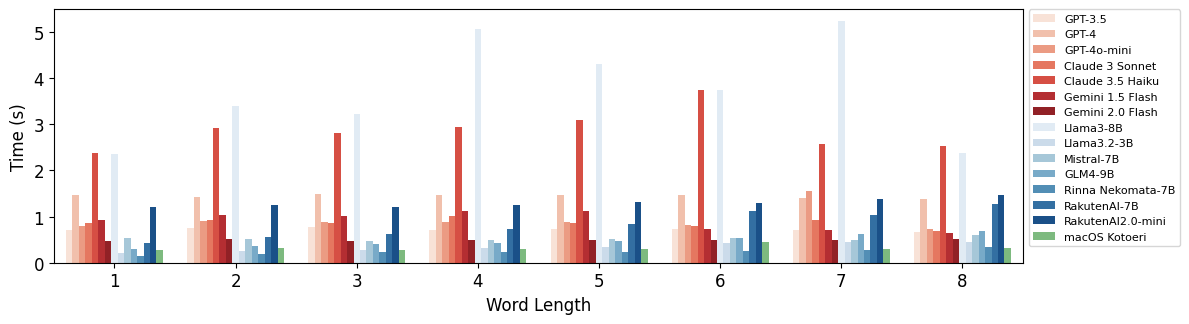

In [24]:
melted_df = pd.melt(data.reindex(models_order).rename(index=MODELS_METADATA['Name'].to_dict()).
                    reset_index(names=['model']), id_vars='model', var_name='wl', value_name='time')

# Define model categories
model_categories = {
    'Closed-Source LLMs': ['GPT-3.5', 'GPT-4', 'GPT-4o-mini', 'Claude 3 Sonnet', 'Claude 3.5 Haiku', 'Gemini 1.5 Flash', 'Gemini 2.0 Flash'],
    'Open-Source LLMs': ['Llama3-8B', 'Llama3.2-3B', 'Mistral-7B', 'GLM4-9B', 'Rinna Nekomata-7B', 'RakutenAI-7B',
'RakutenAI2.0-mini'],
    'Traditional IMEs': ['macOS Kotoeri']
}

# Assign a category to each model
category_map = {model: cat for cat, models in model_categories.items() for model in models}
melted_df['category'] = melted_df['model'].map(category_map)

# Create a color palette grouped by categories
palette = {
    'Closed-Source LLMs': sns.color_palette('Reds', n_colors=len(model_categories['Closed-Source LLMs'])),
    'Open-Source LLMs': sns.color_palette('Blues', n_colors=len(model_categories['Open-Source LLMs'])),
    'Traditional IMEs': sns.color_palette('Greens', n_colors=len(model_categories['Traditional IMEs']))
}

# Flatten the palette colors to match the model order in the dataframe
flat_palette = []
for cat in ['Closed-Source LLMs', 'Open-Source LLMs', 'Traditional IMEs']:
    flat_palette.extend(palette[cat])

# Order the models according to categories for consistent plotting
ordered_models = sum(model_categories.values(), [])

plt.figure(figsize=(12, 3.35))
sns.barplot(x='wl', y='time', hue='model', data=melted_df, hue_order=ordered_models, palette=flat_palette)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Word Length', fontsize=12)
plt.ylabel('Time (s)', fontsize=12)
# plt.title('Chinese Sentence Generation: Text Similarity vs Sentence Length by Model Category')
plt.legend(title='', bbox_to_anchor=(1.0, 1.02), loc='upper left', fontsize=8)
plt.tight_layout()

plt.savefig(f'{FIGURES_FOLDER}/jwg_overall_time_wl.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Text Similarity VS word lengths

In [25]:
df = load_results('Japanese Words_Generation')
models = extract_gen_models(df)
make_columns_numeric(df, models)

In [26]:
models

['gpt4o',
 'gemini2',
 'llama32',
 'GLM4',
 'gpt35',
 'rakuten2',
 'llama3',
 'claude3',
 'mistral',
 'sys_japanese',
 'rakuten',
 'gpt4',
 'claude35',
 'wana',
 'gemini',
 'rinna']

In [27]:
models_order = ['gpt35', 'gpt4', 'gpt4o', 'claude3', 'claude35', 'gemini', 'gemini2', 'llama3', 'llama32', 'mistral', 'GLM4', 'rakuten', 'rakuten2', 'rinna', 'sys_japanese', 'wana']

In [28]:
# models_index = pd.MultiIndex.from_tuples([(get_model_type(x), x) for x in models]).sort_values()
columns = df['len'].unique()


In [29]:
columns

array([2, 5, 3, 4, 1, 6, 7, 8])

#### Kanji

In [30]:
df = load_results('Japanese Words_Generation')
models = extract_gen_models(df)
make_columns_numeric(df, models)

In [31]:
models.remove("wana")

In [32]:
models_order = ['gpt35', 'gpt4', 'gpt4o', 'claude3', 'claude35', 'gemini', 'gemini2', 'llama3', 'llama32', 'mistral', 'GLM4', 'rakuten', 'rakuten2', 'rinna', 'sys_japanese']

In [33]:
# models_index = pd.MultiIndex.from_tuples([(get_model_type(x), x) for x in models]).sort_values()
columns = df['len'].unique()
columns

array([2, 5, 3, 4, 1, 6, 7, 8])

In [34]:
data = pd.DataFrame(index=models, columns=columns, dtype='float64')

for model in models:
    for wl in columns:
        mask = (df['len'] == wl) & (df['AI_type'] == "kanji")
        col_name = model + '_simhash_textsim'
        if col_name in df.columns:
           # numeric_series = pd.to_numeric(df.loc[mask, col_name], errors='coerce')
            #mean_val = numeric_series.mean()
            #data.loc[model, wl] = mean_val
            mean_val = df.loc[mask, col_name].mean()
            data.loc[model, wl] = mean_val

data

,2,5,3,4,1,6,7,8
gpt4o,0.746261,0.781132,0.606857,0.655670,0.635957,0.644522,NaN,NaN
gemini2,0.803765,0.849359,0.725426,0.621297,0.668439,0.696970,NaN,NaN
llama32,0.529822,0.546519,0.517237,0.528420,0.541325,0.535354,NaN,NaN
GLM4,0.543970,0.546218,0.525778,0.550658,0.581671,0.545455,NaN,NaN
gpt35,0.723418,0.591323,0.615519,0.563754,0.624529,0.510101,NaN,NaN
rakuten2,0.519447,0.521152,0.511703,0.524772,0.509277,0.573737,NaN,NaN
llama3,0.551663,0.619257,0.524937,0.552227,0.517109,0.609091,NaN,NaN
claude3,0.710355,0.858974,0.655831,0.655384,0.605571,0.631313,NaN,NaN
mistral,0.578076,0.558223,0.543595,0.501125,0.606733,0.646465,NaN,NaN
sys_japanese,0.736238,0.845656,0.674590,0.681926,0.576883,0.787879,NaN,NaN


In [35]:
data_melt = data.drop(columns=[7,8])
melted_df = pd.melt(data_melt.reindex(models_order).rename(index=MODELS_METADATA['Name'].to_dict()).reset_index(names=['model']), id_vars='model', var_name='wl', value_name='textsim')
melted_df

,model,wl,textsim
0,GPT-3.5,2,0.723418
1,GPT-4,2,0.746320
2,GPT-4o-mini,2,0.746261
3,Claude 3 Sonnet,2,0.710355
4,Claude 3.5 Haiku,2,0.737700
...,...,...,...
85,GLM4-9B,6,0.545455
86,RakutenAI-7B,6,0.535354
87,RakutenAI2.0-mini,6,0.573737
88,Rinna Nekomata-7B,6,0.609169


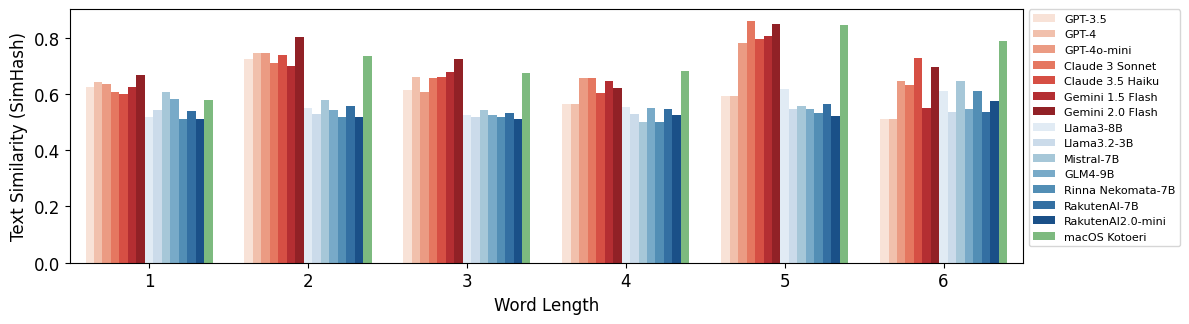

In [36]:
#melted_df = pd.melt(data.reindex(models_order).rename(index=MODELS_METADATA['Name'].to_dict()).reset_index(names=['model']), id_vars='model', var_name='wl', value_name='textsim')

# Define model categories
model_categories = {
    'Closed-Source LLMs': ['GPT-3.5', 'GPT-4', 'GPT-4o-mini', 'Claude 3 Sonnet', 'Claude 3.5 Haiku', 'Gemini 1.5 Flash', 'Gemini 2.0 Flash'],
    'Open-Source LLMs': ['Llama3-8B', 'Llama3.2-3B', 'Mistral-7B', 'GLM4-9B', 'Rinna Nekomata-7B', 'RakutenAI-7B',
'RakutenAI2.0-mini'],
    'Traditional IMEs': ['macOS Kotoeri']
}

# Assign a category to each model
category_map = {model: cat for cat, models in model_categories.items() for model in models}
melted_df['category'] = melted_df['model'].map(category_map)

# Create a color palette grouped by categories
palette = {
    'Closed-Source LLMs': sns.color_palette('Reds', n_colors=len(model_categories['Closed-Source LLMs'])),
    'Open-Source LLMs': sns.color_palette('Blues', n_colors=len(model_categories['Open-Source LLMs'])),
    'Traditional IMEs': sns.color_palette('Greens', n_colors=len(model_categories['Traditional IMEs']))
}

# Flatten the palette colors to match the model order in the dataframe
flat_palette = []
for cat in ['Closed-Source LLMs', 'Open-Source LLMs', 'Traditional IMEs']:
    flat_palette.extend(palette[cat])

# Order the models according to categories for consistent plotting
ordered_models = sum(model_categories.values(), [])

plt.figure(figsize=(12, 3.35))
sns.barplot(x='wl', y='textsim', hue='model', data=melted_df, hue_order=ordered_models, palette=flat_palette)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Word Length',fontsize=12)
plt.ylabel('Text Similarity (SimHash)',fontsize=12)
# plt.title('Chinese Sentence Generation: Text Similarity vs Sentence Length by Model Category')
plt.legend(title='', bbox_to_anchor=(1.0, 1.02), loc='upper left', fontsize=8)
plt.tight_layout()

plt.savefig(f'{FIGURES_FOLDER}/jwg_kanji_textsim_wl.pdf', format='pdf', bbox_inches='tight')
plt.show()



#### Hira

In [37]:
df = load_results('Japanese Words_Generation')
models = extract_gen_models(df)
make_columns_numeric(df, models)

In [38]:
models_order = ['gpt35', 'gpt4', 'gpt4o', 'claude3', 'claude35', 'gemini', 'gemini2', 'llama3', 'llama32', 'mistral', 'GLM4', 'rakuten', 'rakuten2', 'rinna', 'sys_japanese', 'wana']

In [39]:
# models_index = pd.MultiIndex.from_tuples([(get_model_type(x), x) for x in models]).sort_values()
columns = df['len'].unique()
columns

array([2, 5, 3, 4, 1, 6, 7, 8])

In [40]:
data = pd.DataFrame(index=models, columns=columns, dtype='float64')

for model in models:
    for wl in columns:
        mask = (df['len'] == wl) & (df['AI_type'] == "hira")
        col_name = model + '_simhash_textsim'
        if col_name in df.columns:
            mean_val = df.loc[mask, col_name].mean()
            data.loc[model, wl] = mean_val



data

,2,5,3,4,1,6,7,8
gpt4o,0.954545,0.939394,1.000000,0.960736,NaN,0.666667,1.000000,NaN
gemini2,0.976874,0.936133,1.000000,0.960908,NaN,1.000000,1.000000,NaN
llama32,0.901570,0.832334,0.951365,0.840299,NaN,0.858586,1.000000,NaN
GLM4,0.954545,0.794994,0.940110,0.808827,NaN,0.774359,0.703125,NaN
gpt35,0.954545,0.820466,1.000000,0.884923,NaN,0.492152,0.430769,NaN
rakuten2,0.589314,0.760328,0.648585,0.577574,NaN,0.496892,0.757576,NaN
llama3,0.749601,0.705552,0.656852,0.715375,NaN,0.500000,0.515152,NaN
claude3,0.954545,0.971591,1.000000,0.971659,NaN,1.000000,1.000000,NaN
mistral,0.883279,0.937952,0.964286,0.939476,NaN,0.858586,1.000000,NaN
sys_japanese,0.873206,0.712602,0.868873,0.751020,NaN,0.673970,1.000000,NaN


In [41]:
data_melt = data.drop(columns=[1,8])
melted_df = pd.melt(data_melt.reindex(models_order).rename(index=MODELS_METADATA['Name'].to_dict()).
                    reset_index(names=['model']), id_vars='model', var_name='wl', value_name='textsim')
melted_df

,model,wl,textsim
0,GPT-3.5,2,0.954545
1,GPT-4,2,0.954545
2,GPT-4o-mini,2,0.954545
3,Claude 3 Sonnet,2,0.954545
4,Claude 3.5 Haiku,2,0.954545
...,...,...,...
91,RakutenAI-7B,7,1.000000
92,RakutenAI2.0-mini,7,0.757576
93,Rinna Nekomata-7B,7,0.560606
94,macOS Kotoeri,7,1.000000


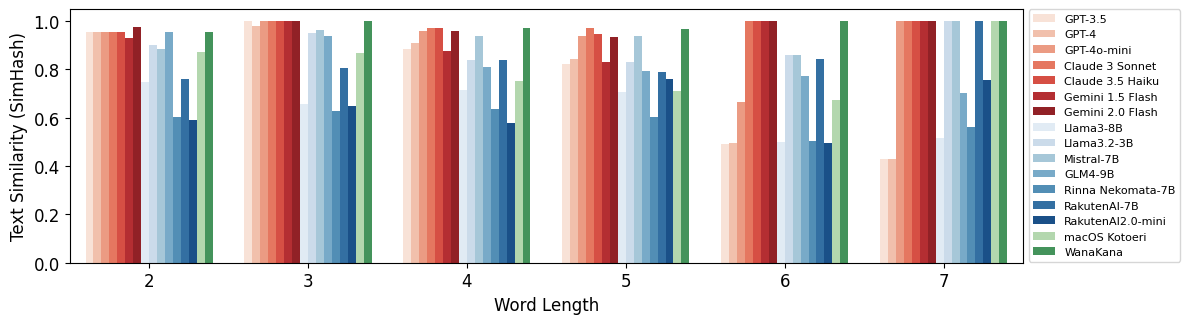

In [42]:
#melted_df = pd.melt(data.reindex(models_order).rename(index=MODELS_METADATA['Name'].to_dict()).reset_index(names=['model']), id_vars='model', var_name='wl', value_name='textsim')

# Define model categories
model_categories = {
    'Closed-Source LLMs': ['GPT-3.5', 'GPT-4', 'GPT-4o-mini', 'Claude 3 Sonnet', 'Claude 3.5 Haiku', 'Gemini 1.5 Flash', 'Gemini 2.0 Flash'],
    'Open-Source LLMs': ['Llama3-8B', 'Llama3.2-3B', 'Mistral-7B', 'GLM4-9B', 'Rinna Nekomata-7B', 'RakutenAI-7B',
'RakutenAI2.0-mini'],
    'Traditional IMEs': ['macOS Kotoeri', 'WanaKana']
}

# Assign a category to each model
category_map = {model: cat for cat, models in model_categories.items() for model in models}
melted_df['category'] = melted_df['model'].map(category_map)

# Create a color palette grouped by categories
palette = {
    'Closed-Source LLMs': sns.color_palette('Reds', n_colors=len(model_categories['Closed-Source LLMs'])),
    'Open-Source LLMs': sns.color_palette('Blues', n_colors=len(model_categories['Open-Source LLMs'])),
    'Traditional IMEs': sns.color_palette('Greens', n_colors=len(model_categories['Traditional IMEs']))
}

# Flatten the palette colors to match the model order in the dataframe
flat_palette = []
for cat in ['Closed-Source LLMs', 'Open-Source LLMs', 'Traditional IMEs']:
    flat_palette.extend(palette[cat])

# Order the models according to categories for consistent plotting
ordered_models = sum(model_categories.values(), [])

plt.figure(figsize=(12, 3.35))
sns.barplot(x='wl', y='textsim', hue='model', data=melted_df, hue_order=ordered_models, palette=flat_palette)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Word Length',fontsize=12)
plt.ylabel('Text Similarity (SimHash)',fontsize=12)
# plt.title('Chinese Sentence Generation: Text Similarity vs Sentence Length by Model Category')
plt.legend(title='', bbox_to_anchor=(1.0, 1.02), loc='upper left', fontsize=8)
plt.tight_layout()

plt.savefig(f'{FIGURES_FOLDER}/jwg_hira_textsim_wl.pdf', format='pdf', bbox_inches='tight')
plt.show()



#### Kata

In [43]:
df = load_results('Japanese Words_Generation')
models = extract_gen_models(df)
make_columns_numeric(df, models)

In [44]:
models_order = ['gpt35', 'gpt4', 'gpt4o', 'claude3', 'claude35', 'gemini', 'gemini2', 'llama3', 'llama32', 'mistral', 'GLM4', 'rakuten', 'rakuten2', 'rinna', 'sys_japanese', 'wana']

In [45]:
# models_index = pd.MultiIndex.from_tuples([(get_model_type(x), x) for x in models]).sort_values()
columns = df['len'].unique()
columns.sort()
columns

array([1, 2, 3, 4, 5, 6, 7, 8])

In [49]:
for model in models:
  for wl in columns:
      if wl in [7, 8]:
          # 把7和8都视为同一个“7+”类别
          col_label = '7+'
          mask = (df['len'].isin([7, 8])) & (df['AI_type'] == 'kata')
      else:
          col_label = wl
          mask = (df['len'] == wl) & (df['AI_type'] == 'kata')

      col_name = model + '_simhash_textsim'
      if col_name in df.columns:
          mean_val = df.loc[mask, col_name].mean()
          data.loc[model, col_label] = mean_val



data

,2,5,3,4,1,6,7,8,7+
gpt4o,0.948485,0.917188,0.961189,1.000000,NaN,0.691919,1.000000,NaN,0.564918
gemini2,0.948485,0.805222,0.957382,0.963203,NaN,0.787879,1.000000,NaN,1.000000
llama32,0.571544,0.608337,0.634237,0.638528,NaN,0.606061,1.000000,NaN,0.522727
GLM4,0.626089,0.600977,0.665404,0.593756,NaN,0.833333,0.703125,NaN,0.712121
gpt35,0.904545,0.809977,0.981061,0.921445,NaN,0.565657,0.430769,NaN,0.529593
rakuten2,0.663636,0.563738,0.567939,0.549872,NaN,0.454545,0.757576,NaN,0.580186
llama3,0.516089,0.707818,0.566268,0.676743,NaN,0.696970,0.515152,NaN,0.522727
claude3,0.948485,0.915530,0.960227,0.935065,NaN,0.787879,1.000000,NaN,0.765152
mistral,0.863636,0.892661,0.833382,0.753696,NaN,0.924242,1.000000,NaN,0.765152
sys_japanese,0.948485,0.669937,0.736791,0.753628,NaN,0.898990,1.000000,NaN,0.787879


In [50]:
desired_order = [2, 3, 4, 5, 6, '7+']
data_melt = data[desired_order]
data_melt

,2,3,4,5,6,7+
gpt4o,0.948485,0.961189,1.000000,0.917188,0.691919,0.564918
gemini2,0.948485,0.957382,0.963203,0.805222,0.787879,1.000000
llama32,0.571544,0.634237,0.638528,0.608337,0.606061,0.522727
GLM4,0.626089,0.665404,0.593756,0.600977,0.833333,0.712121
gpt35,0.904545,0.981061,0.921445,0.809977,0.565657,0.529593
rakuten2,0.663636,0.567939,0.549872,0.563738,0.454545,0.580186
llama3,0.516089,0.566268,0.676743,0.707818,0.696970,0.522727
claude3,0.948485,0.960227,0.935065,0.915530,0.787879,0.765152
mistral,0.863636,0.833382,0.753696,0.892661,0.924242,0.765152
sys_japanese,0.948485,0.736791,0.753628,0.669937,0.898990,0.787879


In [51]:

melted_df = pd.melt(data_melt.reindex(models_order).rename(index=MODELS_METADATA['Name'].to_dict()).
                    reset_index(names=['model']), id_vars='model', var_name='wl', value_name='textsim')
melted_df

,model,wl,textsim
0,GPT-3.5,2,0.904545
1,GPT-4,2,0.948485
2,GPT-4o-mini,2,0.948485
3,Claude 3 Sonnet,2,0.948485
4,Claude 3.5 Haiku,2,0.948485
...,...,...,...
91,RakutenAI-7B,7+,0.750000
92,RakutenAI2.0-mini,7+,0.580186
93,Rinna Nekomata-7B,7+,0.765152
94,macOS Kotoeri,7+,0.787879


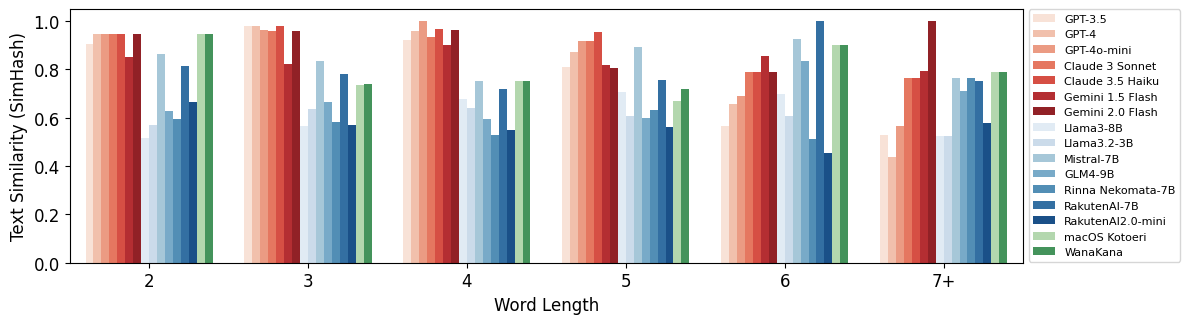

In [52]:
#melted_df = pd.melt(data.reindex(models_order).rename(index=MODELS_METADATA['Name'].to_dict()).reset_index(names=['model']), id_vars='model', var_name='wl', value_name='textsim')

# Define model categories
model_categories = {
    'Closed-Source LLMs': ['GPT-3.5', 'GPT-4', 'GPT-4o-mini', 'Claude 3 Sonnet', 'Claude 3.5 Haiku', 'Gemini 1.5 Flash', 'Gemini 2.0 Flash'],
    'Open-Source LLMs': ['Llama3-8B', 'Llama3.2-3B', 'Mistral-7B', 'GLM4-9B', 'Rinna Nekomata-7B', 'RakutenAI-7B',
'RakutenAI2.0-mini'],
    'Traditional IMEs': ['macOS Kotoeri', 'WanaKana']
}

# Assign a category to each model
category_map = {model: cat for cat, models in model_categories.items() for model in models}
melted_df['category'] = melted_df['model'].map(category_map)

# Create a color palette grouped by categories
palette = {
    'Closed-Source LLMs': sns.color_palette('Reds', n_colors=len(model_categories['Closed-Source LLMs'])),
    'Open-Source LLMs': sns.color_palette('Blues', n_colors=len(model_categories['Open-Source LLMs'])),
    'Traditional IMEs': sns.color_palette('Greens', n_colors=len(model_categories['Traditional IMEs']))
}

# Flatten the palette colors to match the model order in the dataframe
flat_palette = []
for cat in ['Closed-Source LLMs', 'Open-Source LLMs', 'Traditional IMEs']:
    flat_palette.extend(palette[cat])

# Order the models according to categories for consistent plotting
ordered_models = sum(model_categories.values(), [])

plt.figure(figsize=(12, 3.35))
sns.barplot(x='wl', y='textsim', hue='model', data=melted_df, hue_order=ordered_models, palette=flat_palette)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Word Length',fontsize=12)
plt.ylabel('Text Similarity (SimHash)',fontsize=12)
# plt.title('Chinese Sentence Generation: Text Similarity vs Sentence Length by Model Category')
plt.legend(title='', bbox_to_anchor=(1.0, 1.02), loc='upper left', fontsize=8)
plt.tight_layout()

plt.savefig(f'{FIGURES_FOLDER}/jwg_kata_textsim_wl.pdf', format='pdf', bbox_inches='tight')
plt.show()



### Time VS word lengths

#### Kanji

In [ ]:
df = load_results('Japanese Words_Generation')
models = extract_gen_models(df)
make_columns_numeric(df, models)

In [ ]:
models.remove("wana")

In [ ]:
models_order = ['gpt35', 'gpt4', 'gpt4o', 'claude3', 'claude35', 'gemini', 'gemini2', 'llama3', 'llama32', 'mistral', 'GLM4', 'rakuten', 'rakuten2', 'rinna', 'sys_japanese']

In [ ]:
# models_index = pd.MultiIndex.from_tuples([(get_model_type(x), x) for x in models]).sort_values()
columns = df['len'].unique()
columns

array([2, 5, 3, 4, 1, 6, 7, 8])

In [ ]:
data = pd.DataFrame(index=models, columns=columns, dtype='float64')

for model in models:
    for wl in columns:
        mask = (df['len'] == wl) & (df['AI_type'] == "kanji")
        col_name = model + '_time'
        if col_name in df.columns:
            mean_val = df.loc[mask, col_name].mean()
            data.loc[model, wl] = mean_val



data

,2,5,3,4,1,6,7,8
sys_japanese,0.356083,0.483617,0.397885,0.428786,0.275331,0.717945,NaN,NaN
llama3,3.289051,3.501670,2.634344,3.724695,2.359838,5.832028,NaN,NaN
gpt4o,0.916587,0.907615,0.872363,0.882034,0.801853,0.848444,NaN,NaN
claude35,2.951571,4.431746,3.115829,3.077252,2.382024,3.392353,NaN,NaN
gemini,1.046579,0.826657,0.904100,0.845007,0.931704,0.849320,NaN,NaN
rakuten,0.582710,0.963165,0.719108,0.834045,0.425080,1.280507,NaN,NaN
claude3,0.921321,0.875273,0.880204,0.944665,0.860794,0.883573,NaN,NaN
llama32,0.258703,0.332662,0.287319,0.310511,0.209257,0.441315,NaN,NaN
gpt35,0.755619,0.712954,0.788492,0.704461,0.719657,0.736813,NaN,NaN
rakuten2,1.247386,1.550784,1.226155,1.250257,1.202498,1.280390,NaN,NaN


In [ ]:
data_melt = data.drop(columns=[7,8])


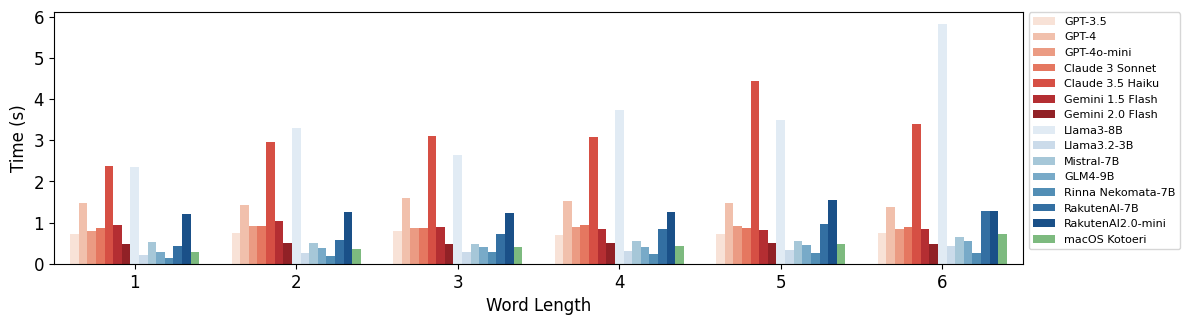

In [ ]:
melted_df = pd.melt(data_melt.reindex(models_order).rename(index=MODELS_METADATA['Name'].to_dict()).reset_index(names=['model']), id_vars='model', var_name='wl', value_name='time')


# Define model categories
model_categories = {
    'Closed-Source LLMs': ['GPT-3.5', 'GPT-4', 'GPT-4o-mini', 'Claude 3 Sonnet', 'Claude 3.5 Haiku', 'Gemini 1.5 Flash', 'Gemini 2.0 Flash'],
    'Open-Source LLMs': ['Llama3-8B', 'Llama3.2-3B', 'Mistral-7B', 'GLM4-9B', 'Rinna Nekomata-7B', 'RakutenAI-7B',
'RakutenAI2.0-mini'],
    'Traditional IMEs': ['macOS Kotoeri']
}

# Assign a category to each model
category_map = {model: cat for cat, models in model_categories.items() for model in models}
melted_df['category'] = melted_df['model'].map(category_map)

# Create a color palette grouped by categories
palette = {
    'Closed-Source LLMs': sns.color_palette('Reds', n_colors=len(model_categories['Closed-Source LLMs'])),
    'Open-Source LLMs': sns.color_palette('Blues', n_colors=len(model_categories['Open-Source LLMs'])),
    'Traditional IMEs': sns.color_palette('Greens', n_colors=len(model_categories['Traditional IMEs']))
}

# Flatten the palette colors to match the model order in the dataframe
flat_palette = []
for cat in ['Closed-Source LLMs', 'Open-Source LLMs', 'Traditional IMEs']:
    flat_palette.extend(palette[cat])

# Order the models according to categories for consistent plotting
ordered_models = sum(model_categories.values(), [])

plt.figure(figsize=(12, 3.35))
sns.barplot(x='wl', y='time', hue='model', data=melted_df, hue_order=ordered_models, palette=flat_palette)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Word Length',fontsize=12)
plt.ylabel('Time (s)',fontsize=12)
# plt.title('Chinese Sentence Generation: Text Similarity vs Sentence Length by Model Category')
plt.legend(title='', bbox_to_anchor=(1.0, 1.02), loc='upper left', fontsize=8)
plt.tight_layout()

plt.savefig(f'{FIGURES_FOLDER}/jwg_kanji_time_wl.pdf', format='pdf', bbox_inches='tight')
plt.show()



#### Hira

In [ ]:
df = load_results('Japanese Words_Generation')
models = extract_gen_models(df)
make_columns_numeric(df, models)

In [ ]:
models_order = ['gpt35', 'gpt4', 'gpt4o', 'claude3', 'claude35', 'gemini', 'gemini2', 'llama3', 'llama32', 'mistral', 'GLM4', 'rakuten', 'rakuten2', 'rinna', 'sys_japanese','wana']

In [ ]:
# models_index = pd.MultiIndex.from_tuples([(get_model_type(x), x) for x in models]).sort_values()
columns = df['len'].unique()
columns

array([2, 5, 3, 4, 1, 6, 7, 8])

In [ ]:
data = pd.DataFrame(index=models, columns=columns, dtype='float64')

for model in models:
    for wl in columns:
        mask = (df['len'] == wl) & (df['AI_type'] == "hira")
        col_name = model + '_time'
        if col_name in df.columns:
            mean_val = df.loc[mask, col_name].mean()
            data.loc[model, wl] = mean_val


data

,2,5,3,4,1,6,7,8
sys_japanese,0.134345,0.292537,0.201241,0.281691,NaN,0.411103,0.462126,NaN
llama3,4.821761,6.042786,4.311829,5.999545,NaN,2.404705,8.360500,NaN
gpt4o,0.795371,0.905386,0.935141,0.879260,NaN,0.798452,2.506641,NaN
wana,0.000304,0.000340,0.000566,0.000409,NaN,0.001095,0.000342,NaN
claude35,2.423963,2.341453,2.516906,2.726018,NaN,3.404558,1.683433,NaN
gemini,1.006982,1.402063,1.192741,1.233975,NaN,0.673770,0.740611,NaN
rakuten,0.331619,0.811726,0.534400,0.705347,NaN,1.071801,1.153150,NaN
claude3,0.925448,0.966797,0.795354,1.093473,NaN,0.816839,0.685972,NaN
llama32,0.211150,0.364149,0.270470,0.317592,NaN,0.428850,0.444983,NaN
gpt35,0.718843,0.759931,0.743145,0.718591,NaN,0.798986,0.734919,NaN


In [ ]:
data_melt = data.drop(columns=[1,8])
melted_df = pd.melt(data_melt.reindex(models_order).rename(index=MODELS_METADATA['Name'].to_dict()).
                    reset_index(names=['model']), id_vars='model', var_name='wl', value_name='time')
melted_df

,model,wl,time
0,GPT-3.5,2,0.718843
1,GPT-4,2,1.373685
2,GPT-4o-mini,2,0.795371
3,Claude 3 Sonnet,2,0.925448
4,Claude 3.5 Haiku,2,2.423963
...,...,...,...
91,RakutenAI-7B,7,1.153150
92,RakutenAI2.0-mini,7,1.375546
93,Rinna Nekomata-7B,7,0.263038
94,macOS Kotoeri,7,0.462126


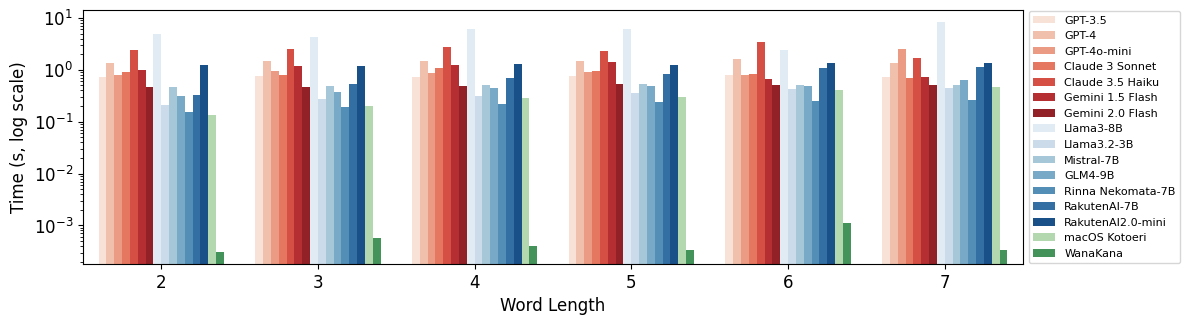

In [ ]:
#melted_df = pd.melt(data.reindex(models_order).rename(index=MODELS_METADATA['Name'].to_dict()).reset_index(names=['model']), id_vars='model', var_name='wl', value_name='textsim')

# Define model categories
model_categories = {
    'Closed-Source LLMs': ['GPT-3.5', 'GPT-4', 'GPT-4o-mini', 'Claude 3 Sonnet', 'Claude 3.5 Haiku', 'Gemini 1.5 Flash', 'Gemini 2.0 Flash'],
    'Open-Source LLMs': ['Llama3-8B', 'Llama3.2-3B', 'Mistral-7B', 'GLM4-9B', 'Rinna Nekomata-7B', 'RakutenAI-7B',
'RakutenAI2.0-mini'],
    'Traditional IMEs': ['macOS Kotoeri', 'WanaKana']
}

# Assign a category to each model
category_map = {model: cat for cat, models in model_categories.items() for model in models}
melted_df['category'] = melted_df['model'].map(category_map)

# Create a color palette grouped by categories
palette = {
    'Closed-Source LLMs': sns.color_palette('Reds', n_colors=len(model_categories['Closed-Source LLMs'])),
    'Open-Source LLMs': sns.color_palette('Blues', n_colors=len(model_categories['Open-Source LLMs'])),
    'Traditional IMEs': sns.color_palette('Greens', n_colors=len(model_categories['Traditional IMEs']))
}

# Flatten the palette colors to match the model order in the dataframe
flat_palette = []
for cat in ['Closed-Source LLMs', 'Open-Source LLMs', 'Traditional IMEs']:
    flat_palette.extend(palette[cat])

# Order the models according to categories for consistent plotting
ordered_models = sum(model_categories.values(), [])

plt.figure(figsize=(12, 3.35))
sns.barplot(x='wl', y='time', hue='model', data=melted_df, hue_order=ordered_models, palette=flat_palette)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Word Length',fontsize=12)
plt.yscale('log')
plt.ylabel('Time (s, log scale)', fontsize=12)
# plt.title('Chinese Sentence Generation: Text Similarity vs Sentence Length by Model Category')
plt.legend(title='', bbox_to_anchor=(1.0, 1.02), loc='upper left', fontsize=8)
plt.tight_layout()

plt.savefig(f'{FIGURES_FOLDER}/jwg_hira_time_wl.pdf', format='pdf', bbox_inches='tight')
plt.show()



#### Kata

In [53]:
df = load_results('Japanese Words_Generation')
models = extract_gen_models(df)
make_columns_numeric(df, models)

In [54]:
models_order = ['gpt35', 'gpt4', 'gpt4o', 'claude3', 'claude35', 'gemini', 'gemini2', 'llama3', 'llama32', 'mistral', 'GLM4', 'rakuten', 'rakuten2', 'rinna', 'sys_japanese', 'wana']

In [55]:
# models_index = pd.MultiIndex.from_tuples([(get_model_type(x), x) for x in models]).sort_values()
columns = df['len'].unique()
columns

array([2, 5, 3, 4, 1, 6, 7, 8])

In [56]:
for model in models:
  for wl in columns:
      if wl in [7, 8]:
          # 把7和8都视为同一个“7+”类别
          col_label = '7+'
          mask = (df['len'].isin([7, 8])) & (df['AI_type'] == 'kata')
      else:
          col_label = wl
          mask = (df['len'] == wl) & (df['AI_type'] == 'kata')

      col_name = model + '_time'
      if col_name in df.columns:
          mean_val = df.loc[mask, col_name].mean()
          data.loc[model, col_label] = mean_val

data

,2,5,3,4,1,6,7,8,7+
gpt4o,0.863673,0.790374,0.855994,0.836194,NaN,0.800197,1.000000,NaN,0.666539
gemini2,0.484086,0.471488,0.466632,0.501095,NaN,0.478221,1.000000,NaN,0.486896
llama32,0.225171,0.333779,0.242214,0.302382,NaN,0.405578,1.000000,NaN,0.444898
GLM4,0.308953,0.490725,0.384516,0.451601,NaN,0.594310,0.703125,NaN,0.657460
gpt35,0.690689,0.674080,0.733459,0.707544,NaN,0.666138,0.430769,NaN,0.669489
rakuten2,1.547748,1.229749,1.191443,1.214171,NaN,1.243683,0.757576,NaN,1.428541
llama3,2.764500,2.149811,3.249212,4.334817,NaN,2.964818,0.515152,NaN,2.243583
claude3,0.876470,0.701123,0.893587,0.856626,NaN,0.693606,1.000000,NaN,0.920477
mistral,0.412486,0.484693,0.448723,0.447340,NaN,0.452817,1.000000,NaN,0.529886
sys_japanese,0.099373,0.180392,0.129271,0.159370,NaN,0.232468,1.000000,NaN,0.238191


In [57]:
data = data.drop(columns=[1,7,8])
desired_order = [2, 3, 4, 5, 6, '7+']
data_melt = data[desired_order]
melted_df = pd.melt(data_melt.reindex(models_order).rename(index=MODELS_METADATA['Name'].to_dict()).
                    reset_index(names=['model']), id_vars='model', var_name='wl', value_name='time')
melted_df

,model,wl,time
0,GPT-3.5,2,0.690689
1,GPT-4,2,1.397080
2,GPT-4o-mini,2,0.863673
3,Claude 3 Sonnet,2,0.876470
4,Claude 3.5 Haiku,2,3.228389
...,...,...,...
91,RakutenAI-7B,7+,1.091372
92,RakutenAI2.0-mini,7+,1.428541
93,Rinna Nekomata-7B,7+,0.307966
94,macOS Kotoeri,7+,0.238191


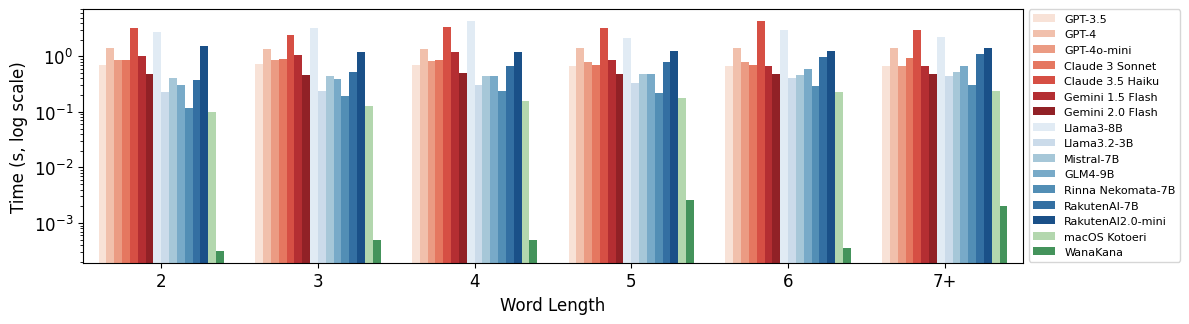

In [58]:
#melted_df = pd.melt(data.reindex(models_order).rename(index=MODELS_METADATA['Name'].to_dict()).reset_index(names=['model']), id_vars='model', var_name='wl', value_name='textsim')

# Define model categories
model_categories = {
    'Closed-Source LLMs': ['GPT-3.5', 'GPT-4', 'GPT-4o-mini', 'Claude 3 Sonnet', 'Claude 3.5 Haiku', 'Gemini 1.5 Flash', 'Gemini 2.0 Flash'],
    'Open-Source LLMs': ['Llama3-8B', 'Llama3.2-3B', 'Mistral-7B', 'GLM4-9B', 'Rinna Nekomata-7B', 'RakutenAI-7B',
'RakutenAI2.0-mini'],
    'Traditional IMEs': ['macOS Kotoeri', 'WanaKana']
}

# Assign a category to each model
category_map = {model: cat for cat, models in model_categories.items() for model in models}
melted_df['category'] = melted_df['model'].map(category_map)

# Create a color palette grouped by categories
palette = {
    'Closed-Source LLMs': sns.color_palette('Reds', n_colors=len(model_categories['Closed-Source LLMs'])),
    'Open-Source LLMs': sns.color_palette('Blues', n_colors=len(model_categories['Open-Source LLMs'])),
    'Traditional IMEs': sns.color_palette('Greens', n_colors=len(model_categories['Traditional IMEs']))
}

# Flatten the palette colors to match the model order in the dataframe
flat_palette = []
for cat in ['Closed-Source LLMs', 'Open-Source LLMs', 'Traditional IMEs']:
    flat_palette.extend(palette[cat])

# Order the models according to categories for consistent plotting
ordered_models = sum(model_categories.values(), [])

plt.figure(figsize=(12, 3.35))
sns.barplot(x='wl', y='time', hue='model', data=melted_df, hue_order=ordered_models, palette=flat_palette)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Word Length',fontsize=12)
plt.yscale('log')
plt.ylabel('Time (s, log scale)', fontsize=12)
# plt.title('Chinese Sentence Generation: Text Similarity vs Sentence Length by Model Category')
plt.legend(title='', bbox_to_anchor=(1.0, 1.02), loc='upper left', fontsize=8)
plt.tight_layout()

plt.savefig(f'{FIGURES_FOLDER}/jwg_kata_time_wl.pdf', format='pdf', bbox_inches='tight')
plt.show()



## Japanese Sentence Generation

In [ ]:
df = load_results('Japanese Sentence_Generation')
models = extract_gen_models(df)
make_columns_numeric(df, models)

<Axes: xlabel='len', ylabel='Count'>

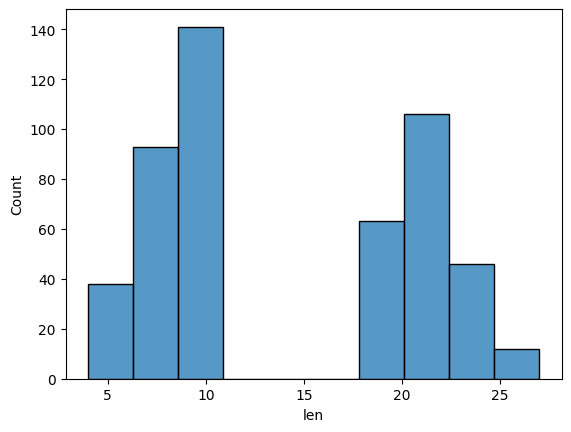

In [ ]:
sns.histplot(df['len'])

In [ ]:
# bucket of ranges
columns = ['<8', '8-16', '16-24', '24+']

df['len_bin'] = pd.cut(df['len'], bins=[0, 8, 16, 24, np.inf], labels=columns)


### Text Similarity Vs Sentence Length

In [ ]:
data = pd.DataFrame(index=models, columns=columns, dtype='float64')

for model in models:
  for sl in columns:
    data.loc[model, sl] = df[df['len_bin'] == sl][model + '_simhash_textsim'].mean()

data

,<8,8-16,16-24,24+
gpt4o,0.870284,0.855129,0.846297,0.772013
gpt4,0.905082,0.880610,0.875193,0.787655
rinna,0.579345,0.538759,0.532755,0.548209
rakuten,0.564973,0.552475,0.555091,0.557600
llama32,0.589000,0.591811,0.577220,0.588978
claude35,0.762483,0.782894,0.821076,0.771688
mistral,0.641405,0.625023,0.633553,0.619577
llama3,0.693746,0.648548,0.644708,0.656303
GLM4,0.622009,0.600009,0.594510,0.564694
gemini,0.798054,0.819154,0.797114,0.717026


In [ ]:
models

['gpt4o',
 'gpt4',
 'rinna',
 'rakuten',
 'llama32',
 'claude35',
 'mistral',
 'llama3',
 'GLM4',
 'gemini',
 'gpt35',
 'rakuten2',
 'gemini2',
 'sys_japanese',
 'claude3']

In [ ]:
models_order = ['gpt35', 'gpt4', 'gpt4o', 'claude3', 'claude35', 'gemini', 'gemini2', 'llama3', 'llama32', 'mistral', 'GLM4', 'rakuten', 'rakuten2', 'rinna', 'sys_japanese']

In [ ]:
melted_df = pd.melt(data.reindex(models_order).rename(index=MODELS_METADATA['Name'].to_dict()).
                    reset_index(names=['model']), id_vars='model', var_name='wl', value_name='textsim')
melted_df

,model,wl,textsim
0,GPT-3.5,<8,0.835933
1,GPT-4,<8,0.905082
2,GPT-4o-mini,<8,0.870284
3,Claude 3 Sonnet,<8,0.849048
4,Claude 3.5 Haiku,<8,0.762483
5,Gemini 1.5 Flash,<8,0.798054
6,Gemini 2.0 Flash,<8,0.906381
7,Llama3-8B,<8,0.693746
8,Llama3.2-3B,<8,0.589000
9,Mistral-7B,<8,0.641405


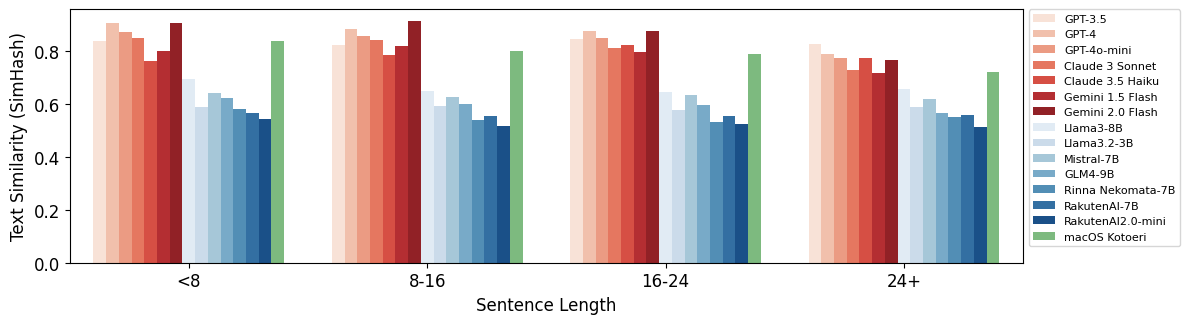

In [ ]:
#melted_df = pd.melt(data.reindex(models_order).rename(index=MODELS_METADATA['Name'].to_dict()).reset_index(names=['model']), id_vars='model', var_name='wl', value_name='textsim')

# Define model categories
model_categories = {
    'Closed-Source LLMs': ['GPT-3.5', 'GPT-4', 'GPT-4o-mini', 'Claude 3 Sonnet', 'Claude 3.5 Haiku', 'Gemini 1.5 Flash', 'Gemini 2.0 Flash'],
    'Open-Source LLMs': ['Llama3-8B', 'Llama3.2-3B', 'Mistral-7B', 'GLM4-9B', 'Rinna Nekomata-7B', 'RakutenAI-7B',
'RakutenAI2.0-mini'],
    'Traditional IMEs': ['macOS Kotoeri']
}

# Assign a category to each model
category_map = {model: cat for cat, models in model_categories.items() for model in models}
melted_df['category'] = melted_df['model'].map(category_map)

# Create a color palette grouped by categories
palette = {
    'Closed-Source LLMs': sns.color_palette('Reds', n_colors=len(model_categories['Closed-Source LLMs'])),
    'Open-Source LLMs': sns.color_palette('Blues', n_colors=len(model_categories['Open-Source LLMs'])),
    'Traditional IMEs': sns.color_palette('Greens', n_colors=len(model_categories['Traditional IMEs']))
}

# Flatten the palette colors to match the model order in the dataframe
flat_palette = []
for cat in ['Closed-Source LLMs', 'Open-Source LLMs', 'Traditional IMEs']:
    flat_palette.extend(palette[cat])

# Order the models according to categories for consistent plotting
ordered_models = sum(model_categories.values(), [])

plt.figure(figsize=(12, 3.35))
sns.barplot(x='wl', y='textsim', hue='model', data=melted_df, hue_order=ordered_models, palette=flat_palette)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Sentence Length',fontsize=12)
plt.ylabel('Text Similarity (SimHash)',fontsize=12)
# plt.title('Chinese Sentence Generation: Text Similarity vs Sentence Length by Model Category')
plt.legend(title='', bbox_to_anchor=(1.0, 1.02), loc='upper left', fontsize=8)
plt.tight_layout()

plt.savefig(f'{FIGURES_FOLDER}/jsg_textsim_wl.pdf', format='pdf', bbox_inches='tight')
plt.show()



### Time Vs Sentence Length

In [ ]:
models

['gpt4o',
 'gpt4',
 'rinna',
 'rakuten',
 'llama32',
 'claude35',
 'mistral',
 'llama3',
 'GLM4',
 'gemini',
 'gpt35',
 'rakuten2',
 'gemini2',
 'sys_japanese',
 'claude3']

In [ ]:
data = pd.DataFrame(index=models, columns=columns, dtype='float64')

for model in models:
  for sl in columns:
    # 1. Extract the subset of data
        subset = df.loc[df['len_bin'] == sl, model + '_time']

        # 2. Replace empty strings '' with NaN (if the column is not already numeric)
        subset = subset.replace('', np.nan)

        # 3. Convert to numeric type (any values that cannot be converted will become NaN)
        subset = pd.to_numeric(subset, errors='coerce')

        # 4. Calculate the mean; mean() will automatically skip NaN values
        data.loc[model, sl] = subset.mean()

data

,<8,8-16,16-24,24+
gpt4o,0.955425,1.041266,1.328175,1.419229
gpt4,1.993024,2.383451,3.440010,3.851668
rinna,1.089374,1.470111,3.113578,3.450023
rakuten,1.669811,2.230064,4.435468,5.151993
llama32,0.453317,0.553075,0.913521,1.096516
claude35,2.296307,2.918421,3.779503,3.656469
mistral,0.598282,0.667821,0.936895,1.054609
llama3,4.212623,4.409934,4.816209,5.068538
GLM4,1.664912,1.793526,2.317118,2.312318
gemini,0.946513,0.978768,0.972935,1.183250


In [ ]:
models_order = ['gpt35', 'gpt4', 'gpt4o', 'claude3', 'claude35', 'gemini', 'gemini2',
                'llama3', 'llama32', 'mistral', 'GLM4', 'rakuten', 'rakuten2', 'rinna', 'sys_japanese']

In [ ]:
melted_df = pd.melt(data.reindex(models_order).rename(index=MODELS_METADATA['Name'].to_dict()).
                    reset_index(names=['model']), id_vars='model', var_name='wl', value_name='time')

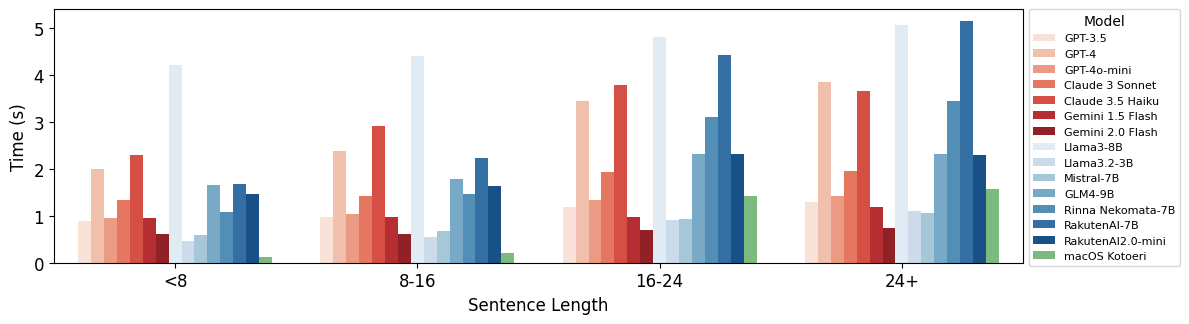

In [ ]:
melted_df = pd.melt(data.reindex(models_order).rename(index=MODELS_METADATA['Name'].to_dict()).
                    reset_index(names=['model']), id_vars='model', var_name='wl', value_name='time')

# Define model categories
model_categories = {
    'Closed-Source LLMs': ['GPT-3.5', 'GPT-4', 'GPT-4o-mini', 'Claude 3 Sonnet', 'Claude 3.5 Haiku', 'Gemini 1.5 Flash', 'Gemini 2.0 Flash'],
    'Open-Source LLMs': ['Llama3-8B', 'Llama3.2-3B', 'Mistral-7B', 'GLM4-9B', 'Rinna Nekomata-7B', 'RakutenAI-7B',
'RakutenAI2.0-mini'],
    'Traditional IMEs': ['macOS Kotoeri']
}

# Assign a category to each model
category_map = {model: cat for cat, models in model_categories.items() for model in models}
melted_df['category'] = melted_df['model'].map(category_map)

# Create a color palette grouped by categories
palette = {
    'Closed-Source LLMs': sns.color_palette('Reds', n_colors=len(model_categories['Closed-Source LLMs'])),
    'Open-Source LLMs': sns.color_palette('Blues', n_colors=len(model_categories['Open-Source LLMs'])),
    'Traditional IMEs': sns.color_palette('Greens', n_colors=len(model_categories['Traditional IMEs']))
}

# Flatten the palette colors to match the model order in the dataframe
flat_palette = []
for cat in ['Closed-Source LLMs', 'Open-Source LLMs', 'Traditional IMEs']:
    flat_palette.extend(palette[cat])

# Order the models according to categories for consistent plotting
ordered_models = sum(model_categories.values(), [])

plt.figure(figsize=(12, 3.35))
sns.barplot(x='wl', y='time', hue='model', data=melted_df, hue_order=ordered_models, palette=flat_palette)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Sentence Length',fontsize=12)
plt.ylabel('Time (s)',fontsize=12)
# plt.title('Chinese Sentence Generation: Text Similarity vs Sentence Length by Model Category')
plt.legend(title='Model', bbox_to_anchor=(1.0, 1.02), loc='upper left', fontsize=8)
plt.tight_layout()

plt.savefig(f'{FIGURES_FOLDER}/jsg_time_wl.pdf', format='pdf', bbox_inches='tight')
plt.show()



## Chinese Error Correction

In [49]:
df = load_results('Chinese Error Correction')
models = extract_err_models(df) # Use error correction extraction

# Make Columns Numeric
for model in models:
  df[model + '_incorrectstrings_simhash_textsim'] = pd.to_numeric(df[model + '_incorrectstrings_simhash_textsim'], errors='coerce')
  df[model + '_incorrectstrings_time'] = pd.to_numeric(df[model + '_incorrectstrings_time'], errors='coerce')

  if model == 'pycorrector':
    continue

  df[model + '_pinyin_simhash_textsim'] = pd.to_numeric(df[model + '_pinyin_simhash_textsim'], errors='coerce')
  df[model + '_pinyin_time'] = pd.to_numeric(df[model + '_pinyin_time'], errors='coerce')

In [ ]:
models

['pycorrector',
 'gpt4o',
 'llama3',
 'claude35',
 'baichuan',
 'gemini',
 'claude3',
 'llama32',
 'gpt35',
 'gpt4',
 'mistral',
 'gemini2',
 'qwen2',
 'GLM4']

In [ ]:
models_index = pd.MultiIndex.from_tuples([(get_model_type(x), x) for x in models]).sort_values()
columns_index = pd.MultiIndex.from_tuples([('textsim', 'valid'), ('textsim', 'invalid'), ('time', 'valid'), ('time', 'invalid')])

In [ ]:
mean_df = pd.DataFrame(index=models_index, columns=columns_index, dtype='float64')

valid_df = df[df['pseudo_type'] == 'valid']
invalid_df = df[df['pseudo_type'] == 'invalid']

for model in models:
  if model == 'pycorrector':
    mean_df.drop(index=(get_model_type(model), model), inplace=True)
    continue

  mean_df.loc[(get_model_type(model), model), ('textsim', 'valid'),] = valid_df[model + '_pinyin_simhash_textsim'].mean()
  mean_df.loc[(get_model_type(model), model), ('textsim', 'invalid'),] = invalid_df[model + '_pinyin_simhash_textsim'].mean()
  mean_df.loc[(get_model_type(model), model), ('time', 'valid')] = valid_df[model + '_pinyin_time'].mean()
  mean_df.loc[(get_model_type(model), model), ('time', 'invalid')] = invalid_df[model + '_pinyin_time'].mean()

In [ ]:
models_order = ['gpt35', 'gpt4', 'gpt4o', 'claude3', 'claude35', 'gemini', 'gemini2', 'llama3', 'llama32', 'mistral', 'GLM4', 'baichuan', 'qwen2']
mean_df.droplevel(0, axis=0).reindex(models_order).rename(MODELS_METADATA['Name'].to_dict())

textsim                time          
                     valid   invalid     valid   invalid
GPT-3.5           0.665574  0.665787  1.949243  1.915390
GPT-4             0.719661  0.731252  5.749834  5.013921
GPT-4o-mini       0.754201  0.736791  2.636654  2.316440
Claude 3 Sonnet   0.660591  0.652341  2.948467  3.001667
Claude 3.5 Haiku  0.674293  0.657498  7.558919  7.619488
Gemini 1.5 Flash  0.704028  0.710955  2.055310  2.035356
Gemini 2.0 Flash  0.784230  0.805815  1.143480  1.081932
Llama3-8B         0.557639  0.557128  2.182270  2.298702
Llama3.2-3B       0.527978  0.525063  1.063091  1.031511
Mistral-7B        0.540865  0.539335  3.174287  3.236423
GLM4-9B           0.581424  0.584368  4.692024  4.733061
Baichuan-7B       0.532731  0.526710  1.984081  1.709568
Qwen2-7B          0.556478  0.554559  2.538850  2.661191

### Pinyin: Textsim vs Noise

In [ ]:
models = ['gpt35', 'gpt4', 'gpt4o', 'claude3', 'claude35', 'gemini', 'gemini2', 'llama3', 'llama32', 'mistral', 'GLM4', 'baichuan', 'qwen2']
columns = sorted(df['noise_num'].unique())

In [ ]:
data = pd.DataFrame(index=models, columns=columns, dtype='float64')

for model in models:
  if model == 'pycorrector':
    data.drop(index=model, inplace=True)
    continue

  for num in columns:
    data.loc[model, num] = df[df['noise_num'] == num][model + '_pinyin_simhash_textsim'].mean()

data

,0,1,2,3,4,5
gpt35,0.704278,0.698092,0.668569,0.637757,0.618176,0.605978
gpt4,0.762072,0.761874,0.732845,0.704162,0.660023,0.629009
gpt4o,0.804771,0.788936,0.763093,0.732638,0.673437,0.655341
claude3,0.688260,0.681715,0.667152,0.639973,0.618966,0.606321
claude35,0.711480,0.696343,0.677423,0.646430,0.624908,0.613429
gemini,0.735267,0.733905,0.708140,0.687645,0.662038,0.652973
gemini2,0.831394,0.839361,0.802347,0.762847,0.701312,0.692480
llama3,0.557194,0.563758,0.564974,0.560716,0.535709,0.543474
llama32,0.515402,0.530260,0.525135,0.525190,0.534978,0.530161
mistral,0.541796,0.538682,0.543434,0.544930,0.538866,0.535175


In [ ]:
melted_df = pd.melt(data.rename(MODELS_METADATA['Name'].to_dict()).
                    reset_index(names=['model']), id_vars='model', var_name='wl', value_name='textsim')

#rename GPT4o Mini to GPT4o
melted_df['model'] = melted_df['model'].replace('GPT-4o-mini', 'GPT-4o')

melted_df

,model,wl,textsim
0,GPT-3.5,0,0.704278
1,GPT-4,0,0.762072
2,GPT-4o,0,0.804771
3,Claude 3 Sonnet,0,0.688260
4,Claude 3.5 Haiku,0,0.711480
...,...,...,...
73,Llama3.2-3B,5,0.530161
74,Mistral-7B,5,0.535175
75,GLM4-9B,5,0.561555
76,Baichuan-7B,5,0.528358


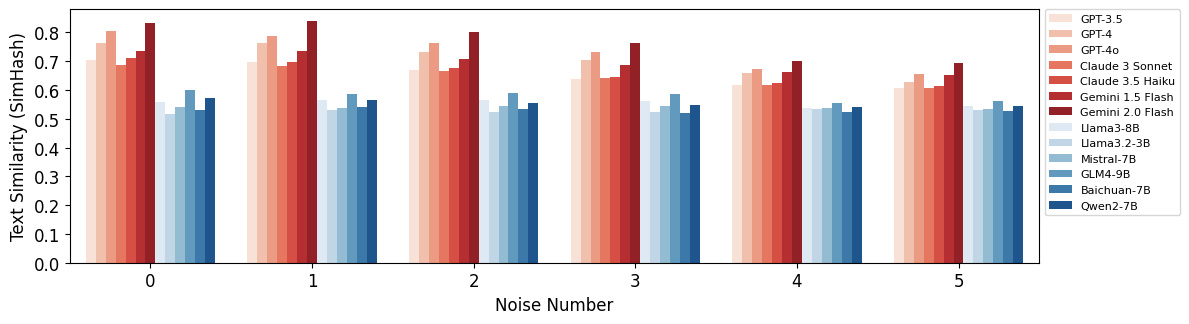

In [ ]:

# Define model categories
model_categories = {
    'Closed-Source LLMs': ['GPT-3.5', 'GPT-4', 'GPT-4o', 'Claude 3 Sonnet', 'Claude 3.5 Haiku', 'Gemini 1.5 Flash', 'Gemini 2.0 Flash'],
    'Open-Source LLMs': ['Llama3-8B', 'Llama3.2-3B', 'Mistral-7B', 'GLM4-9B','Baichuan-7B', 'Qwen2-7B'],
    #'Chinese LLMs': []
}

# Assign a category to each model
category_map = {model: cat for cat, models in model_categories.items() for model in models}
melted_df['category'] = melted_df['model'].map(category_map)

# Create a color palette grouped by categories
palette = {
    'Closed-Source LLMs': sns.color_palette('Reds', n_colors=len(model_categories['Closed-Source LLMs'])),
    'Open-Source LLMs': sns.color_palette('Blues', n_colors=len(model_categories['Open-Source LLMs'])),
    #'Chinese LLMs': sns.color_palette('Greens', n_colors=len(model_categories['Chinese LLMs']))
}

# Flatten the palette colors to match the model order in the dataframe
flat_palette = []
for cat in ['Closed-Source LLMs', 'Open-Source LLMs']:
    flat_palette.extend(palette[cat])

# Order the models according to categories for consistent plotting
ordered_models = sum(model_categories.values(), [])

plt.figure(figsize=(12, 3.35))
sns.barplot(x='wl', y='textsim', hue='model', data=melted_df, hue_order=ordered_models, palette=flat_palette)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Noise Number',fontsize=12)
plt.ylabel('Text Similarity (SimHash)',fontsize=12)
# plt.title('Chinese Word Generation: Text Similarity vs Word Length by Model Category')
plt.legend(title='', bbox_to_anchor=(1.0, 1.02), loc='upper left', fontsize=8)
plt.tight_layout()

plt.savefig(f'{FIGURES_FOLDER}/cec_pinyin_textsim_noise.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Pinyin: Time vs Noise

In [ ]:
models = ['gpt35', 'gpt4', 'gpt4o', 'claude3', 'claude35', 'gemini', 'gemini2', 'llama3', 'llama32', 'mistral', 'GLM4', 'baichuan', 'qwen2']
columns = sorted(df['noise_num'].unique())

In [ ]:
data = pd.DataFrame(index=models, columns=columns, dtype='float64')

for model in models:
  if model == 'pycorrector':
    data.drop(index=model, inplace=True)
    continue

  for num in columns:
    data.loc[model, num] = df[df['noise_num'] == num][model + '_pinyin_time'].mean()

data

,0,1,2,3,4,5
gpt35,1.782978,2.152266,1.902619,1.867968,1.796021,1.816314
gpt4,5.790984,5.431684,5.752264,6.010199,5.503753,5.079474
gpt4o,2.537028,2.534971,2.719004,2.554536,2.543759,2.386129
claude3,2.728130,2.811188,2.772036,3.432519,3.415794,3.033512
claude35,7.056798,7.277776,7.753112,8.001980,7.937141,7.712806
gemini,1.997843,2.062469,2.150687,2.014994,2.072071,1.873857
gemini2,0.937131,1.447397,1.004597,1.080710,0.821863,1.060361
llama3,2.103868,2.118435,2.395858,2.246522,2.245745,2.090864
llama32,1.051567,1.049435,1.065684,1.065828,1.072993,1.030261
mistral,2.860377,3.310550,3.456503,3.122445,2.950881,2.924974


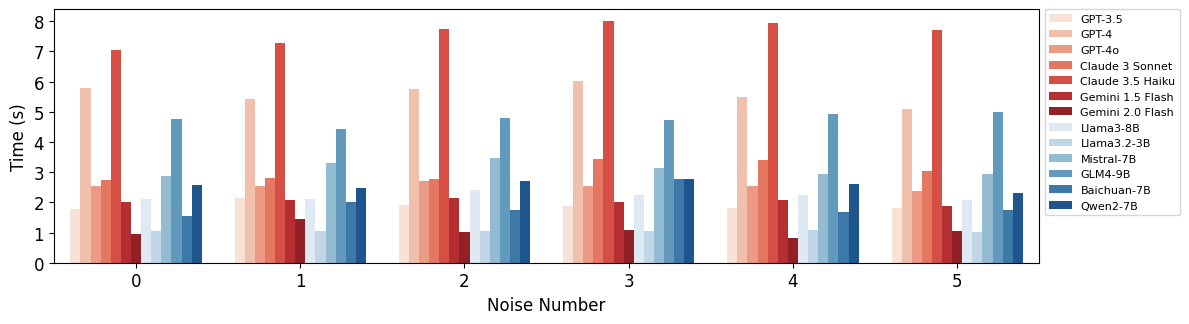

In [ ]:
melted_df = pd.melt(data.reindex(models_order).rename(MODELS_METADATA['Name'].to_dict()).
                    reset_index(names=['model']), id_vars='model', var_name='wl', value_name='time')

#rename GPT4o Mini to GPT4o
melted_df['model'] = melted_df['model'].replace('GPT-4o-mini', 'GPT-4o')

# Define model categories
model_categories = {
    'Closed-Source LLMs': ['GPT-3.5', 'GPT-4', 'GPT-4o', 'Claude 3 Sonnet', 'Claude 3.5 Haiku', 'Gemini 1.5 Flash', 'Gemini 2.0 Flash'],
    'Open-Source LLMs': ['Llama3-8B', 'Llama3.2-3B', 'Mistral-7B', 'GLM4-9B','Baichuan-7B', 'Qwen2-7B'],
    #'Chinese LLMs': []
}


# Assign a category to each model
category_map = {model: cat for cat, models in model_categories.items() for model in models}
melted_df['category'] = melted_df['model'].map(category_map)

# Create a color palette grouped by categories
palette = {
    'Closed-Source LLMs': sns.color_palette('Reds', n_colors=len(model_categories['Closed-Source LLMs'])),
    'Open-Source LLMs': sns.color_palette('Blues', n_colors=len(model_categories['Open-Source LLMs'])),
    #'Chinese LLMs': sns.color_palette('Greens', n_colors=len(model_categories['Chinese LLMs']))
}

# Flatten the palette colors to match the model order in the dataframe
flat_palette = []
for cat in ['Closed-Source LLMs', 'Open-Source LLMs']:
    flat_palette.extend(palette[cat])

# Order the models according to categories for consistent plotting
ordered_models = sum(model_categories.values(), [])

plt.figure(figsize=(12, 3.35))
sns.barplot(x='wl', y='time', hue='model', data=melted_df, hue_order=ordered_models, palette=flat_palette)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Noise Number',fontsize=12)
plt.ylabel('Time (s)',fontsize=12)
# plt.title('Chinese Word Generation: Text Similarity vs Word Length by Model Category')
plt.legend(title='', bbox_to_anchor=(1.0, 1.02), loc='upper left', fontsize=8)
plt.tight_layout()

plt.savefig(f'{FIGURES_FOLDER}/cec_pinyin_time_noise.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Chinese Characters: Textsim vs Noise

In [ ]:
df = load_results('Chinese Error Correction')
models = extract_err_models(df) # Use error correction extraction

# Make Columns Numeric
for model in models:
  df[model + '_incorrectstrings_simhash_textsim'] = pd.to_numeric(df[model + '_incorrectstrings_simhash_textsim'], errors='coerce')
  df[model + '_incorrectstrings_time'] = pd.to_numeric(df[model + '_incorrectstrings_time'], errors='coerce')

  if model == 'pycorrector':
    continue

  df[model + '_pinyin_simhash_textsim'] = pd.to_numeric(df[model + '_pinyin_simhash_textsim'], errors='coerce')
  df[model + '_pinyin_time'] = pd.to_numeric(df[model + '_pinyin_time'], errors='coerce')

In [ ]:
mean_df = pd.DataFrame(index=models_index, columns=['textsim', 'time'], dtype='float64')

for model in models:
  mean_df.loc[(get_model_type(model), model), 'textsim',] = valid_df[model + '_incorrectstrings_simhash_textsim'].mean()
  mean_df.loc[(get_model_type(model), model), 'time',] = invalid_df[model + '_incorrectstrings_time'].mean()

In [ ]:
models_order = ['gpt35', 'gpt4', 'gpt4o', 'claude3', 'claude35', 'gemini', 'gemini2', 'llama3', 'llama32', 'mistral', 'GLM4', 'baichuan', 'qwen2', 'pycorrector']
mean_df.droplevel(0, axis=0).reindex(models_order).rename(MODELS_METADATA['Name'].to_dict())

,textsim,time
GPT-3.5,0.789998,1.808626
GPT-4,0.819202,4.781005
GPT-4o-mini,0.860663,1.645145
Claude 3 Sonnet,0.783115,2.987533
Claude 3.5 Haiku,0.794042,6.783265
Gemini 1.5 Flash,0.754545,2.413172
Gemini 2.0 Flash,0.802447,0.874799
Llama3-8B,0.718932,2.396866
Llama3.2-3B,0.675214,1.101990
Mistral-7B,0.700691,2.277959


In [ ]:
models = ['gpt35', 'gpt4', 'gpt4o', 'claude3', 'claude35', 'gemini', 'gemini2', 'llama3', 'llama32', 'mistral', 'GLM4', 'baichuan', 'qwen2', 'pycorrector']
columns = sorted(df['noise_num'].unique())

In [ ]:
data = pd.DataFrame(index=models, columns=columns, dtype='float64')

for model in models:
  for num in columns:
    data.loc[model, num] = df[df['noise_num'] == num][model + '_incorrectstrings_simhash_textsim'].mean()

data

,0,1,2,3,4,5
gpt35,0.869073,0.790572,0.735733,0.674765,0.647785,0.640020
gpt4,0.892677,0.813500,0.765604,0.697383,0.666962,0.653898
gpt4o,0.913133,0.845632,0.803789,0.744429,0.707603,0.697820
claude3,0.837880,0.772475,0.738697,0.690063,0.649095,0.635173
claude35,0.867006,0.792759,0.747796,0.684857,0.647924,0.630325
gemini,0.759958,0.746286,0.720936,0.668565,0.629260,0.628713
gemini2,0.854452,0.796320,0.745655,0.709097,0.662646,0.649014
llama3,0.764128,0.716527,0.678852,0.642429,0.620778,0.607835
llama32,0.740295,0.675657,0.642873,0.608877,0.588457,0.582306
mistral,0.739562,0.697890,0.663015,0.627464,0.608882,0.601301


In [ ]:
melted_df = pd.melt(data.rename(MODELS_METADATA['Name'].to_dict()).
                    reset_index(names=['model']), id_vars='model', var_name='wl', value_name='textsim')

#rename GPT4o Mini to GPT4o
melted_df['model'] = melted_df['model'].replace('GPT-4o-mini', 'GPT-4o')

melted_df

,model,wl,textsim
0,GPT-3.5,0,0.869073
1,GPT-4,0,0.892677
2,GPT-4o,0,0.913133
3,Claude 3 Sonnet,0,0.837880
4,Claude 3.5 Haiku,0,0.867006
...,...,...,...
79,Mistral-7B,5,0.601301
80,GLM4-9B,5,0.618852
81,Baichuan-7B,5,0.572246
82,Qwen2-7B,5,0.607160


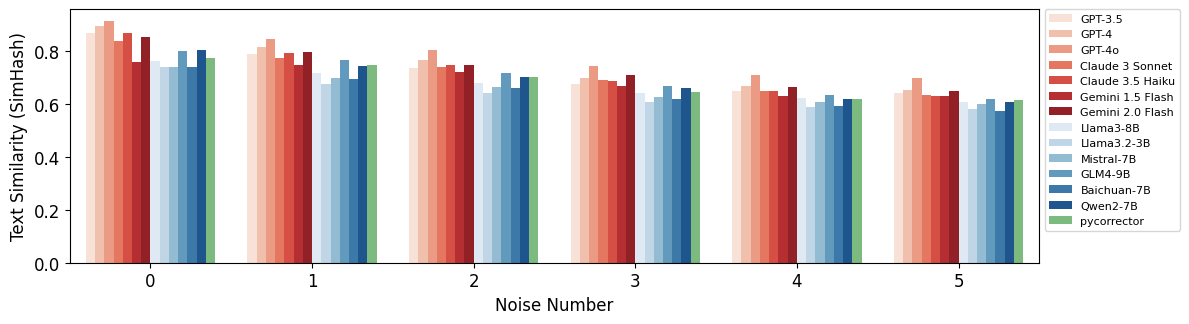

In [ ]:
# Define model categories
model_categories = {
    'Closed-Source LLMs': ['GPT-3.5', 'GPT-4', 'GPT-4o', 'Claude 3 Sonnet', 'Claude 3.5 Haiku', 'Gemini 1.5 Flash', 'Gemini 2.0 Flash'],
    'Open-Source LLMs': ['Llama3-8B', 'Llama3.2-3B', 'Mistral-7B', 'GLM4-9B','Baichuan-7B', 'Qwen2-7B'],
    #'Chinese LLMs': [],
    'Baselines': ['pycorrector']
}


# Assign a category to each model
category_map = {model: cat for cat, models in model_categories.items() for model in models}
melted_df['category'] = melted_df['model'].map(category_map)

# Create a color palette grouped by categories
palette = {
    'Closed-Source LLMs': sns.color_palette('Reds', n_colors=len(model_categories['Closed-Source LLMs'])),
    'Open-Source LLMs': sns.color_palette('Blues', n_colors=len(model_categories['Open-Source LLMs'])),
    #'Chinese LLMs': sns.color_palette('Greens', n_colors=len(model_categories['Chinese LLMs'])),
    'Baselines': sns.color_palette('Greens', n_colors=len(model_categories['Baselines']))
}#no greys

# Flatten the palette colors to match the model order in the dataframe
flat_palette = []
for cat in ['Closed-Source LLMs', 'Open-Source LLMs','Baselines']:
    flat_palette.extend(palette[cat])

# Order the models according to categories for consistent plotting
ordered_models = sum(model_categories.values(), [])

plt.figure(figsize=(12, 3.35))
sns.barplot(x='wl', y='textsim', hue='model', data=melted_df, hue_order=ordered_models, palette=flat_palette)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Noise Number',fontsize=12)
plt.ylabel('Text Similarity (SimHash)',fontsize=12)
# plt.title('Chinese Word Generation: Text Similarity vs Word Length by Model Category')
plt.legend(title='', bbox_to_anchor=(1.0, 1.02), loc='upper left', fontsize=8)
plt.tight_layout()

plt.savefig(f'{FIGURES_FOLDER}/cec_char_textsim_noise.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Chinese Characters: Time vs Noise

In [ ]:
df = load_results('Chinese Error Correction')
models = extract_err_models(df) # Use error correction extraction

# Make Columns Numeric
for model in models:
  df[model + '_incorrectstrings_simhash_textsim'] = pd.to_numeric(df[model + '_incorrectstrings_simhash_textsim'], errors='coerce')
  df[model + '_incorrectstrings_time'] = pd.to_numeric(df[model + '_incorrectstrings_time'], errors='coerce')

  if model == 'pycorrector':
    continue

  df[model + '_pinyin_simhash_textsim'] = pd.to_numeric(df[model + '_pinyin_simhash_textsim'], errors='coerce')
  df[model + '_pinyin_time'] = pd.to_numeric(df[model + '_pinyin_time'], errors='coerce')

In [ ]:
mean_df = pd.DataFrame(index=models_index, columns=['textsim', 'time'], dtype='float64')

for model in models:
  mean_df.loc[(get_model_type(model), model), 'textsim',] = valid_df[model + '_incorrectstrings_simhash_textsim'].mean()
  mean_df.loc[(get_model_type(model), model), 'time',] = invalid_df[model + '_incorrectstrings_time'].mean()

In [ ]:
models = ['gpt35', 'gpt4', 'gpt4o', 'claude3', 'claude35', 'gemini', 'gemini2', 'llama3', 'llama32', 'mistral', 'GLM4', 'baichuan', 'qwen2', 'pycorrector']
columns = sorted(df['noise_num'].unique())

In [ ]:
data = pd.DataFrame(index=models, columns=columns, dtype='float64')

for model in models:
  for num in columns:
    data.loc[model, num] = df[df['noise_num'] == num][model + '_incorrectstrings_time'].mean()

data

,0,1,2,3,4,5
gpt35,1.674926,1.597065,1.761580,1.719304,1.636443,1.566325
gpt4,4.117095,4.700571,4.491046,4.447469,4.194350,4.507755
gpt4o,1.457312,1.455164,1.522656,1.527574,1.562559,1.551949
claude3,2.162300,2.228337,2.352222,2.539257,2.457038,2.559798
claude35,4.832253,5.635329,5.597691,5.772633,5.964826,5.582125
gemini,2.273499,2.494513,2.466945,2.419805,2.330066,2.347013
gemini2,0.725497,1.236217,0.853916,0.996638,0.686220,0.805299
llama3,1.969811,1.917546,2.124040,2.065022,2.138545,2.033992
llama32,1.066848,1.059861,1.097959,1.092125,1.078778,1.074412
mistral,2.176832,2.174236,2.263685,2.226630,2.189215,2.178702


In [ ]:
melted_df = pd.melt(data.reindex(models).rename(MODELS_METADATA['Name'].to_dict()).
                    reset_index(names=['model']), id_vars='model', var_name='wl', value_name='time')

#rename GPT4o Mini to GPT4o
melted_df['model'] = melted_df['model'].replace('GPT-4o-mini', 'GPT-4o')

melted_df

,model,wl,time
0,GPT-3.5,0,1.674926
1,GPT-4,0,4.117095
2,GPT-4o,0,1.457312
3,Claude 3 Sonnet,0,2.162300
4,Claude 3.5 Haiku,0,4.832253
...,...,...,...
79,Mistral-7B,5,2.178702
80,GLM4-9B,5,5.328045
81,Baichuan-7B,5,1.562187
82,Qwen2-7B,5,1.973321


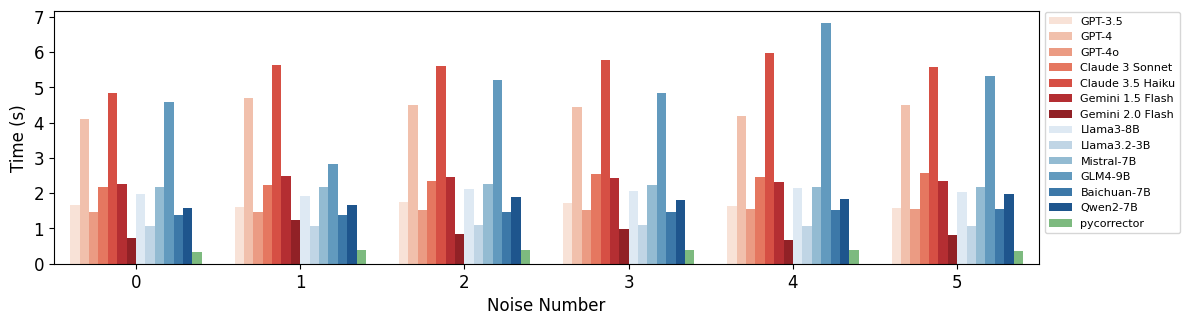

In [ ]:
# Define model categories
model_categories = {
    'Closed-Source LLMs': ['GPT-3.5', 'GPT-4', 'GPT-4o', 'Claude 3 Sonnet', 'Claude 3.5 Haiku', 'Gemini 1.5 Flash', 'Gemini 2.0 Flash'],
    'Open-Source LLMs': ['Llama3-8B', 'Llama3.2-3B', 'Mistral-7B', 'GLM4-9B','Baichuan-7B', 'Qwen2-7B'],
    #'Chinese LLMs': [],
    'Baselines': ['pycorrector']
}

# Assign a category to each model
category_map = {model: cat for cat, models in model_categories.items() for model in models}
melted_df['category'] = melted_df['model'].map(category_map)

# Create a color palette grouped by categories
palette = {
    'Closed-Source LLMs': sns.color_palette('Reds', n_colors=len(model_categories['Closed-Source LLMs'])),
    'Open-Source LLMs': sns.color_palette('Blues', n_colors=len(model_categories['Open-Source LLMs'])),
    #'Chinese LLMs': sns.color_palette('Greens', n_colors=len(model_categories['Chinese LLMs'])),
    'Baselines': sns.color_palette('Greens', n_colors=len(model_categories['Baselines']))
}#no greys

# Flatten the palette colors to match the model order in the dataframe
flat_palette = []
for cat in ['Closed-Source LLMs', 'Open-Source LLMs','Baselines']:
    flat_palette.extend(palette[cat])

# Order the models according to categories for consistent plotting
ordered_models = sum(model_categories.values(), [])

plt.figure(figsize=(12, 3.35))
sns.barplot(x='wl', y='time', hue='model', data=melted_df, hue_order=ordered_models, palette=flat_palette)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Noise Number',fontsize=12)
plt.ylabel('Time (s)',fontsize=12)
# plt.title('Chinese Word Generation: Text Similarity vs Word Length by Model Category')
plt.legend(title='', bbox_to_anchor=(1.0, 1.02), loc='upper left', fontsize=8)
plt.tight_layout()

plt.savefig(f'{FIGURES_FOLDER}/cec_char_time_noise.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Japanese Error Correction

In [ ]:
df = load_results('Japanese Error Correction')
models = extract_err_models(df) # Use error correction extraction

In [ ]:
models

['gpt4o',
 'gpt4',
 'rinna',
 'rakuten',
 'llama32',
 'claude35',
 'mistral',
 'llama3',
 'GLM4',
 'gemini',
 'gpt35',
 'opennmt',
 'rakuten2',
 'gemini2',
 'claude3']

In [ ]:
models_index = pd.MultiIndex.from_tuples([(get_model_type(x), x) for x in models]).sort_values()
columns = ['textsim', 'time']

Create and populate the DataFrame.

### Romanji: Romanji vs Noise

In [ ]:
models = ['gpt35', 'gpt4', 'gpt4o', 'claude3', 'claude35', 'gemini', 'gemini2', 'llama3', 'llama32', 'mistral', 'GLM4','rinna', 'rakuten', 'rakuten2']
columns = sorted(df['noise_num'].unique())

In [ ]:
data = pd.DataFrame(index=models, columns=columns, dtype='float64')

for model in models:
  if model == 'opennmt':
    data.drop(index=model, inplace=True)
    continue

  for num in columns:
    data.loc[model, num] = df[df['noise_num'] == num][model + '_romanji_simhash_textsim'].mean()

data

,0,1,2
gpt35,0.774288,0.761965,0.768354
gpt4,0.818681,0.812697,0.824690
gpt4o,0.871426,0.852585,0.858725
claude3,0.763524,0.735036,0.730840
claude35,0.789198,0.789179,0.779024
gemini,0.750877,0.738988,0.746726
gemini2,0.858459,0.839631,0.861460
llama3,0.588207,0.594517,0.599776
llama32,0.536570,0.540705,0.532243
mistral,0.576515,0.579954,0.579371


In [ ]:
melted_df = pd.melt(data.rename(MODELS_METADATA['Name'].to_dict()).
                    reset_index(names=['model']), id_vars='model', var_name='wl', value_name='textsim')

#rename GPT4o Mini to GPT4o
melted_df['model'] = melted_df['model'].replace('GPT-4o-mini', 'GPT-4o')

melted_df

,model,wl,textsim
0,GPT-3.5,0,0.774288
1,GPT-4,0,0.818681
2,GPT-4o,0,0.871426
3,Claude 3 Sonnet,0,0.763524
4,Claude 3.5 Haiku,0,0.789198
5,Gemini 1.5 Flash,0,0.750877
6,Gemini 2.0 Flash,0,0.858459
7,Llama3-8B,0,0.588207
8,Llama3.2-3B,0,0.536570
9,Mistral-7B,0,0.576515


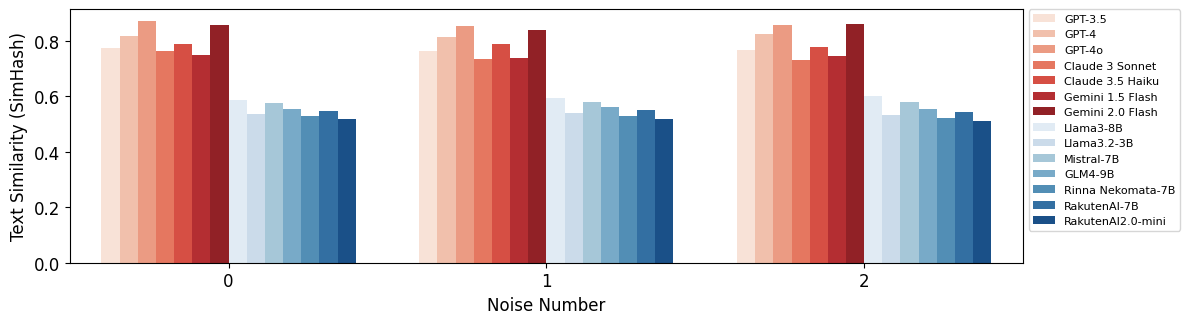

In [ ]:

# Define model categories
model_categories = {
    'Closed-Source LLMs': ['GPT-3.5', 'GPT-4', 'GPT-4o', 'Claude 3 Sonnet', 'Claude 3.5 Haiku', 'Gemini 1.5 Flash', 'Gemini 2.0 Flash'],
    'Open-Source LLMs': ['Llama3-8B', 'Llama3.2-3B', 'Mistral-7B', 'GLM4-9B','Rinna Nekomata-7B', 'RakutenAI-7B', 'RakutenAI2.0-mini']
    #'Japanese LLMs': []
}

# Assign a category to each model
category_map = {model: cat for cat, models in model_categories.items() for model in models}
melted_df['category'] = melted_df['model'].map(category_map)

# Create a color palette grouped by categories
palette = {
    'Closed-Source LLMs': sns.color_palette('Reds', n_colors=len(model_categories['Closed-Source LLMs'])),
    'Open-Source LLMs': sns.color_palette('Blues', n_colors=len(model_categories['Open-Source LLMs']))
    #'Japanese LLMs': sns.color_palette('Greens', n_colors=len(model_categories['Japanese LLMs']))
}

# Flatten the palette colors to match the model order in the dataframe
flat_palette = []
for cat in ['Closed-Source LLMs', 'Open-Source LLMs']:
    flat_palette.extend(palette[cat])

# Order the models according to categories for consistent plotting
ordered_models = sum(model_categories.values(), [])

plt.figure(figsize=(12, 3.35))
sns.barplot(x='wl', y='textsim', hue='model', data=melted_df, hue_order=ordered_models, palette=flat_palette)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Noise Number',fontsize=12)
plt.ylabel('Text Similarity (SimHash)',fontsize=12)
# plt.title('Chinese Word Generation: Text Similarity vs Word Length by Model Category')
plt.legend(title='', bbox_to_anchor=(1.0, 1.02), loc='upper left', fontsize=8)
plt.tight_layout()

plt.savefig(f'{FIGURES_FOLDER}/jec_romanji_textsim_noise.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Romanji: Time vs Noise

In [ ]:
models = ['gpt35', 'gpt4', 'gpt4o', 'claude3', 'claude35', 'gemini', 'gemini2', 'llama3', 'llama32', 'mistral', 'GLM4','rinna', 'rakuten', 'rakuten2']
columns = sorted(df['noise_num'].unique())

In [ ]:
data = pd.DataFrame(index=models, columns=columns, dtype='float64')

for model in models:
  if model == 'opennmt':
    data.drop(index=model, inplace=True)
    continue

  for num in columns:
    data.loc[model, num] = df[df['noise_num'] == num][model + '_romanji_time'].mean()

data

,0,1,2
gpt35,2.176259,2.318248,2.164651
gpt4,6.842271,6.965701,6.516951
gpt4o,1.855902,1.899087,1.933879
claude3,2.721350,2.941623,2.769064
claude35,7.004584,7.087943,6.953460
gemini,0.751204,0.817652,0.727000
gemini2,0.684160,0.748128,0.738275
llama3,3.352618,3.573543,3.269392
llama32,1.170240,1.178681,1.171615
mistral,2.655636,2.859298,2.710118


In [ ]:
melted_df = pd.melt(data.rename(MODELS_METADATA['Name'].to_dict()).
                    reset_index(names=['model']), id_vars='model', var_name='wl', value_name='time')

#rename GPT4o Mini to GPT4o
melted_df['model'] = melted_df['model'].replace('GPT-4o-mini', 'GPT-4o')

melted_df

,model,wl,time
0,GPT-3.5,0,2.176259
1,GPT-4,0,6.842271
2,GPT-4o,0,1.855902
3,Claude 3 Sonnet,0,2.721350
4,Claude 3.5 Haiku,0,7.004584
5,Gemini 1.5 Flash,0,0.751204
6,Gemini 2.0 Flash,0,0.684160
7,Llama3-8B,0,3.352618
8,Llama3.2-3B,0,1.170240
9,Mistral-7B,0,2.655636


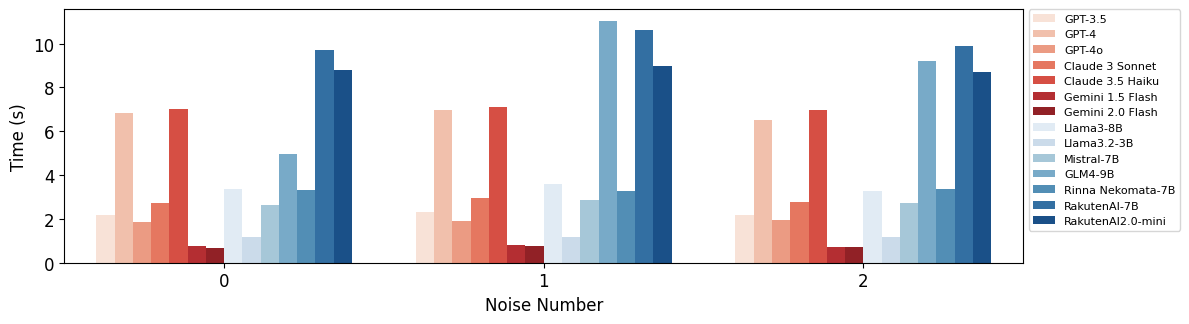

In [ ]:

# Define model categories
model_categories = {
    'Closed-Source LLMs': ['GPT-3.5', 'GPT-4', 'GPT-4o', 'Claude 3 Sonnet', 'Claude 3.5 Haiku', 'Gemini 1.5 Flash', 'Gemini 2.0 Flash'],
    'Open-Source LLMs': ['Llama3-8B', 'Llama3.2-3B', 'Mistral-7B', 'GLM4-9B','Rinna Nekomata-7B', 'RakutenAI-7B', 'RakutenAI2.0-mini'],
    #'Japanese LLMs': []
}

# Assign a category to each model
category_map = {model: cat for cat, models in model_categories.items() for model in models}
melted_df['category'] = melted_df['model'].map(category_map)

# Create a color palette grouped by categories
palette = {
    'Closed-Source LLMs': sns.color_palette('Reds', n_colors=len(model_categories['Closed-Source LLMs'])),
    'Open-Source LLMs': sns.color_palette('Blues', n_colors=len(model_categories['Open-Source LLMs'])),
    #'Japanese LLMs': sns.color_palette('Greens', n_colors=len(model_categories['Japanese LLMs']))
}

# Flatten the palette colors to match the model order in the dataframe
flat_palette = []
for cat in ['Closed-Source LLMs', 'Open-Source LLMs']:
    flat_palette.extend(palette[cat])

# Order the models according to categories for consistent plotting
ordered_models = sum(model_categories.values(), [])

plt.figure(figsize=(12, 3.35))
sns.barplot(x='wl', y='time', hue='model', data=melted_df, hue_order=ordered_models, palette=flat_palette)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Noise Number',fontsize=12)
plt.ylabel('Time (s)',fontsize=12)
# plt.title('Chinese Word Generation: Text Similarity vs Word Length by Model Category')
plt.legend(title='', bbox_to_anchor=(1.0, 1.02), loc='upper left', fontsize=8)
plt.tight_layout()

plt.savefig(f'{FIGURES_FOLDER}/jec_romanji_time_noise.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Japanese Characters: Textsim vs Noise

In [ ]:
models = ['gpt35', 'gpt4', 'gpt4o', 'claude3', 'claude35', 'gemini', 'gemini2', 'llama3', 'llama32', 'mistral','GLM4', 'rinna', 'rakuten', 'rakuten2','opennmt']
columns = sorted(df['noise_num'].unique())

In [ ]:
data = pd.DataFrame(index=models, columns=columns, dtype='float64')

for model in models:

  for num in columns:
    data.loc[model, num] = df[df['noise_num'] == num][model + '_incorrectstrings_simhash_textsim'].mean()

data

,0,1,2
gpt35,0.888929,0.912090,0.895587
gpt4,0.906743,0.927268,0.908027
gpt4o,0.957896,0.954471,0.961239
claude3,0.866853,0.875458,0.848061
claude35,0.879156,0.917103,0.887761
gemini,0.800195,0.820620,0.822933
gemini2,0.870698,0.873835,0.871365
llama3,0.820499,0.845560,0.836860
llama32,0.716504,0.711575,0.718139
mistral,0.790547,0.803224,0.790315


In [ ]:
melted_df = pd.melt(data.rename(MODELS_METADATA['Name'].to_dict()).
                    reset_index(names=['model']), id_vars='model', var_name='wl', value_name='textsim')

#rename GPT4o Mini to GPT4o
melted_df['model'] = melted_df['model'].replace('GPT-4o-mini', 'GPT-4o')

melted_df

,model,wl,textsim
0,GPT-3.5,0,0.888929
1,GPT-4,0,0.906743
2,GPT-4o,0,0.957896
3,Claude 3 Sonnet,0,0.866853
4,Claude 3.5 Haiku,0,0.879156
5,Gemini 1.5 Flash,0,0.800195
6,Gemini 2.0 Flash,0,0.870698
7,Llama3-8B,0,0.820499
8,Llama3.2-3B,0,0.716504
9,Mistral-7B,0,0.790547


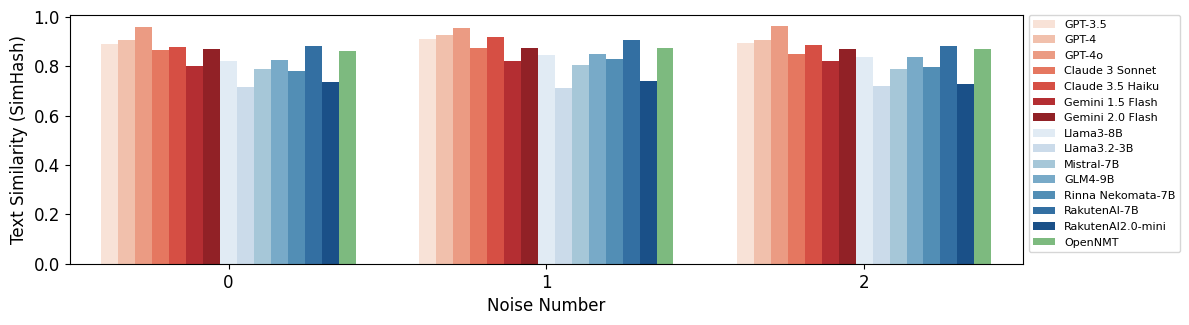

In [ ]:
# Define model categories
'''
model_categories = {
    'Closed-Source LLMs': ['GPT3.5', 'GPT4', 'GPT4o', 'Claude3 Sonnet', 'Claude3.5 Haiku', 'Gemini1.5 Flash', 'Gemini2.0 Flash'],
    'Open-Source LLMs': ['Llama3-8B', 'Llama3.2-3B', 'Mistral-7B', 'GLM4-9B'],
    'Japanese LLMs': ['Rinna Nekomata-7B', 'RakutenAI-7B','RakutenAI2.0-mini'],
    'Baselines': ['OpenNMT']
}
'''

model_categories = {
    'Closed-Source LLMs': ['GPT-3.5', 'GPT-4', 'GPT-4o', 'Claude 3 Sonnet', 'Claude 3.5 Haiku', 'Gemini 1.5 Flash', 'Gemini 2.0 Flash'],
    'Open-Source LLMs': ['Llama3-8B', 'Llama3.2-3B', 'Mistral-7B', 'GLM4-9B','Rinna Nekomata-7B', 'RakutenAI-7B','RakutenAI2.0-mini'],
    'Baselines': ['OpenNMT']
}


# Assign a category to each model
category_map = {model: cat for cat, models in model_categories.items() for model in models}
melted_df['category'] = melted_df['model'].map(category_map)

# Create a color palette grouped by categories
palette = {
    'Closed-Source LLMs': sns.color_palette('Reds', n_colors=len(model_categories['Closed-Source LLMs'])),
    'Open-Source LLMs': sns.color_palette('Blues', n_colors=len(model_categories['Open-Source LLMs'])),
    #'Japanese LLMs': sns.color_palette('Greens', n_colors=len(model_categories['Japanese LLMs'])),
    'Baselines': sns.color_palette('Greens', n_colors=len(model_categories['Baselines']))
}
# no Greys

# Flatten the palette colors to match the model order in the dataframe
flat_palette = []
for cat in ['Closed-Source LLMs', 'Open-Source LLMs', 'Baselines']:
    flat_palette.extend(palette[cat])

# Order the models according to categories for consistent plotting
ordered_models = sum(model_categories.values(), [])

plt.figure(figsize=(12, 3.35))
sns.barplot(x='wl', y='textsim', hue='model', data=melted_df, hue_order=ordered_models, palette=flat_palette)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Noise Number',fontsize=12)
plt.ylabel('Text Similarity (SimHash)',fontsize=12)
# plt.title('Chinese Word Generation: Text Similarity vs Word Length by Model Category')
plt.legend(title='', bbox_to_anchor=(1.0, 1.02), loc='upper left', fontsize=8)
plt.tight_layout()

plt.savefig(f'{FIGURES_FOLDER}/jec_char_textsim_noise.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Japanese Characters: Time vs Noise

In [ ]:
df = load_results('Japanese Error Correction')
models = extract_err_models(df) # Use error correction extraction

In [ ]:
models = ['gpt35', 'gpt4', 'gpt4o', 'claude3', 'claude35', 'gemini', 'gemini2', 'llama3', 'llama32', 'mistral', 'GLM4','rinna', 'rakuten', 'rakuten2','opennmt']
columns = sorted(df['noise_num'].unique())

In [ ]:
df['noise_num'].unique()

array([1, 2, 0])

In [ ]:
data = pd.DataFrame(index=models, columns=columns, dtype='float64')

for model in models:
  for num in columns:
    data.loc[model, num] = pd.to_numeric(
    df[df['noise_num'] == num][model + "_incorrectstrings_time"],
    errors='coerce').mean()
    #data.loc[model, num] = df[df['noise_num'] == num][model + "_incorrectstrings_time"].mean()

data

,0,1,2
gpt35,2.011428,1.995284,1.878865
gpt4,5.181492,5.731329,5.198167
gpt4o,1.600764,1.700403,1.608706
claude3,2.055810,2.227336,2.058547
claude35,4.594626,4.688148,4.595862
gemini,0.776649,0.821785,0.731171
gemini2,0.946324,1.100044,1.036659
llama3,2.952271,3.247559,3.004440
llama32,1.151569,1.162613,1.152596
mistral,2.449726,2.578685,2.435047


In [ ]:
melted_df = pd.melt(data.rename(MODELS_METADATA['Name'].to_dict()).
                    reset_index(names=['model']), id_vars='model', var_name='wl', value_name='time')

#rename GPT4o Mini to GPT4o
melted_df['model'] = melted_df['model'].replace('GPT-4o-mini', 'GPT-4o')

melted_df

,model,wl,time
0,GPT-3.5,0,2.011428
1,GPT-4,0,5.181492
2,GPT-4o,0,1.600764
3,Claude 3 Sonnet,0,2.055810
4,Claude 3.5 Haiku,0,4.594626
5,Gemini 1.5 Flash,0,0.776649
6,Gemini 2.0 Flash,0,0.946324
7,Llama3-8B,0,2.952271
8,Llama3.2-3B,0,1.151569
9,Mistral-7B,0,2.449726


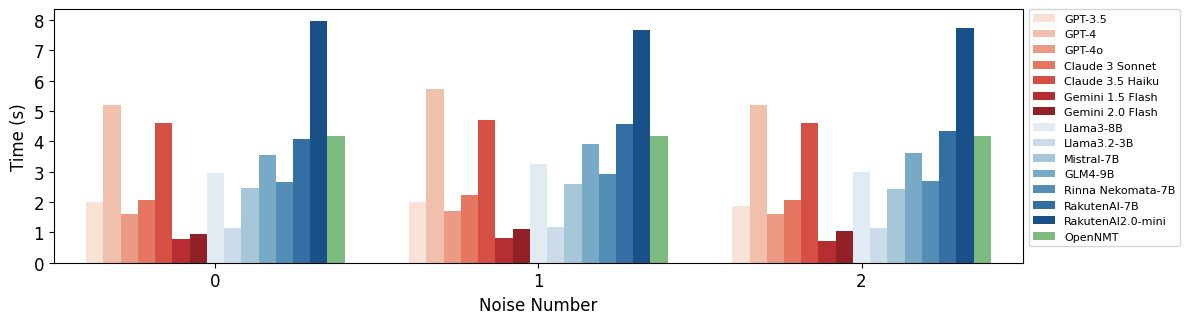

In [ ]:

# Define model categories
model_categories = {
    'Closed-Source LLMs': ['GPT-3.5', 'GPT-4', 'GPT-4o', 'Claude 3 Sonnet', 'Claude 3.5 Haiku', 'Gemini 1.5 Flash', 'Gemini 2.0 Flash'],
    'Open-Source LLMs': ['Llama3-8B', 'Llama3.2-3B', 'Mistral-7B', 'GLM4-9B','Rinna Nekomata-7B', 'RakutenAI-7B', 'RakutenAI2.0-mini'],
    #'Japanese LLMs': [],
    'Baselines': ['OpenNMT']
}

# Assign a category to each model
category_map = {model: cat for cat, models in model_categories.items() for model in models}
melted_df['category'] = melted_df['model'].map(category_map)

# Create a color palette grouped by categories
palette = {
    'Closed-Source LLMs': sns.color_palette('Reds', n_colors=len(model_categories['Closed-Source LLMs'])),
    'Open-Source LLMs': sns.color_palette('Blues', n_colors=len(model_categories['Open-Source LLMs'])),
    #'Japanese LLMs': sns.color_palette('Greens', n_colors=len(model_categories['Japanese LLMs'])),
    'Baselines': sns.color_palette('Greens', n_colors=len(model_categories['Baselines']))
}

# Flatten the palette colors to match the model order in the dataframe
flat_palette = []
for cat in ['Closed-Source LLMs', 'Open-Source LLMs','Baselines']:
    flat_palette.extend(palette[cat])

# Order the models according to categories for consistent plotting
ordered_models = sum(model_categories.values(), [])

plt.figure(figsize=(12, 3.35))
sns.barplot(x='wl', y='time', hue='model', data=melted_df, hue_order=ordered_models, palette=flat_palette)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Noise Number',fontsize=12)
plt.ylabel('Time (s)',fontsize=12)
# plt.title('Chinese Word Generation: Text Similarity vs Word Length by Model Category')
plt.legend(title='', bbox_to_anchor=(1.0, 1.02), loc='upper left', fontsize=8)
plt.tight_layout()


plt.savefig(f'{FIGURES_FOLDER}/jec_char_time_noise.pdf', format='pdf', bbox_inches='tight')
plt.show()